In [1]:
import sys

print(sys.version)  # 3.6.8

3.6.8 (default, Dec 24 2018, 19:24:27) 
[GCC 5.4.0 20160609]


In [117]:
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm, Colormap, Normalize
import matplotlib.patches as patches

import numpy as np
import pandas as pd

import h5py

import pickle
import cv2
import os

import PIL
import time
import pathlib

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, r2_score

from pandas.plotting import scatter_matrix

from scipy.stats import gaussian_kde

from math import sqrt

from itertools import combinations, combinations_with_replacement



In [3]:
pd.set_option("display.float_format", lambda x: "{:.3f}".format(x))

In [4]:
df = pd.read_csv("/data/fp_ica.csv")
df = df.set_index("ID")
df[:5].T

ID                    2829_105      999_37    7770_55A     2140_92B  \
Unnamed: 0                   0           1           2            3   
true_year                0.520       0.360       0.200        0.520   
prediction               0.564       0.407       0.392        0.500   
row                          0           1           2            3   
factor0                  0.611      -2.766      -4.549       -0.829   
factor1                  1.785      -0.138       0.465        1.609   
factor2                 -0.388      -0.335       1.008        0.456   
factor3                 -0.324       0.763      -0.274       -0.606   
factor4                  0.403       0.294      -0.669       -0.178   
factor5                 -0.914       1.408      -0.723        0.384   
factor6                  0.172      -0.895       0.421        0.331   
year                      1995        1987        1979         1995   
N_Housings                 512         232        3060         1185   
N_Units                     64         232         263          129   
Max_Floors                  25          14          12           21   
Min_Floors                  13          10          12           10   
sgg                 4113500000  1174000000  2650000000   4113500000   
sido_sgg_name      경기도 성남시 분당구     서울시 강동구     부산시 수영구  경기도 성남시 분당구   
sido                4100000000  1100000000  2600000000   4100000000   
sido_name                  경기도         서울시         부산시          경기도   
sido_cluster_code            1           0           5            1   
sido_cluster                경기          서울      부산울산경남           경기   
Area                    84.690      27.610      41.520       67.430   
norm_log_area           -0.010      -3.228      -2.057       -0.665   
area_85                   True       False       False        False   
Entrance                   복도식         복도식         복도식          계단식   
Rooms                        3           1           2            3   
Baths                        2           1           1            1   

ID                     509_73  
Unnamed: 0                  4  
true_year               0.500  
prediction              0.486  
row                         4  
factor0                -0.539  
factor1                 1.325  
factor2                -0.499  
factor3                 0.784  
factor4                 0.302  
factor5                -0.240  
factor6                -0.236  
year                     1994  
N_Housings                300  
N_Units                   300  
Max_Floors                  6  
Min_Floors                  6  
sgg                1165000000  
sido_sgg_name         서울시 서초구  
sido               1100000000  
sido_name                 서울시  
sido_cluster_code           0  
sido_cluster               서울  
Area                   52.470  
norm_log_area          -1.385  
area_85                 False  
Entrance                  복도식  
Rooms                       2  
Baths                       1

In [47]:
df_pixel = pd.read_csv("/data/fp_pixel.csv")
df_pixel = df_pixel.set_index("ID")
df = df.join(df_pixel)

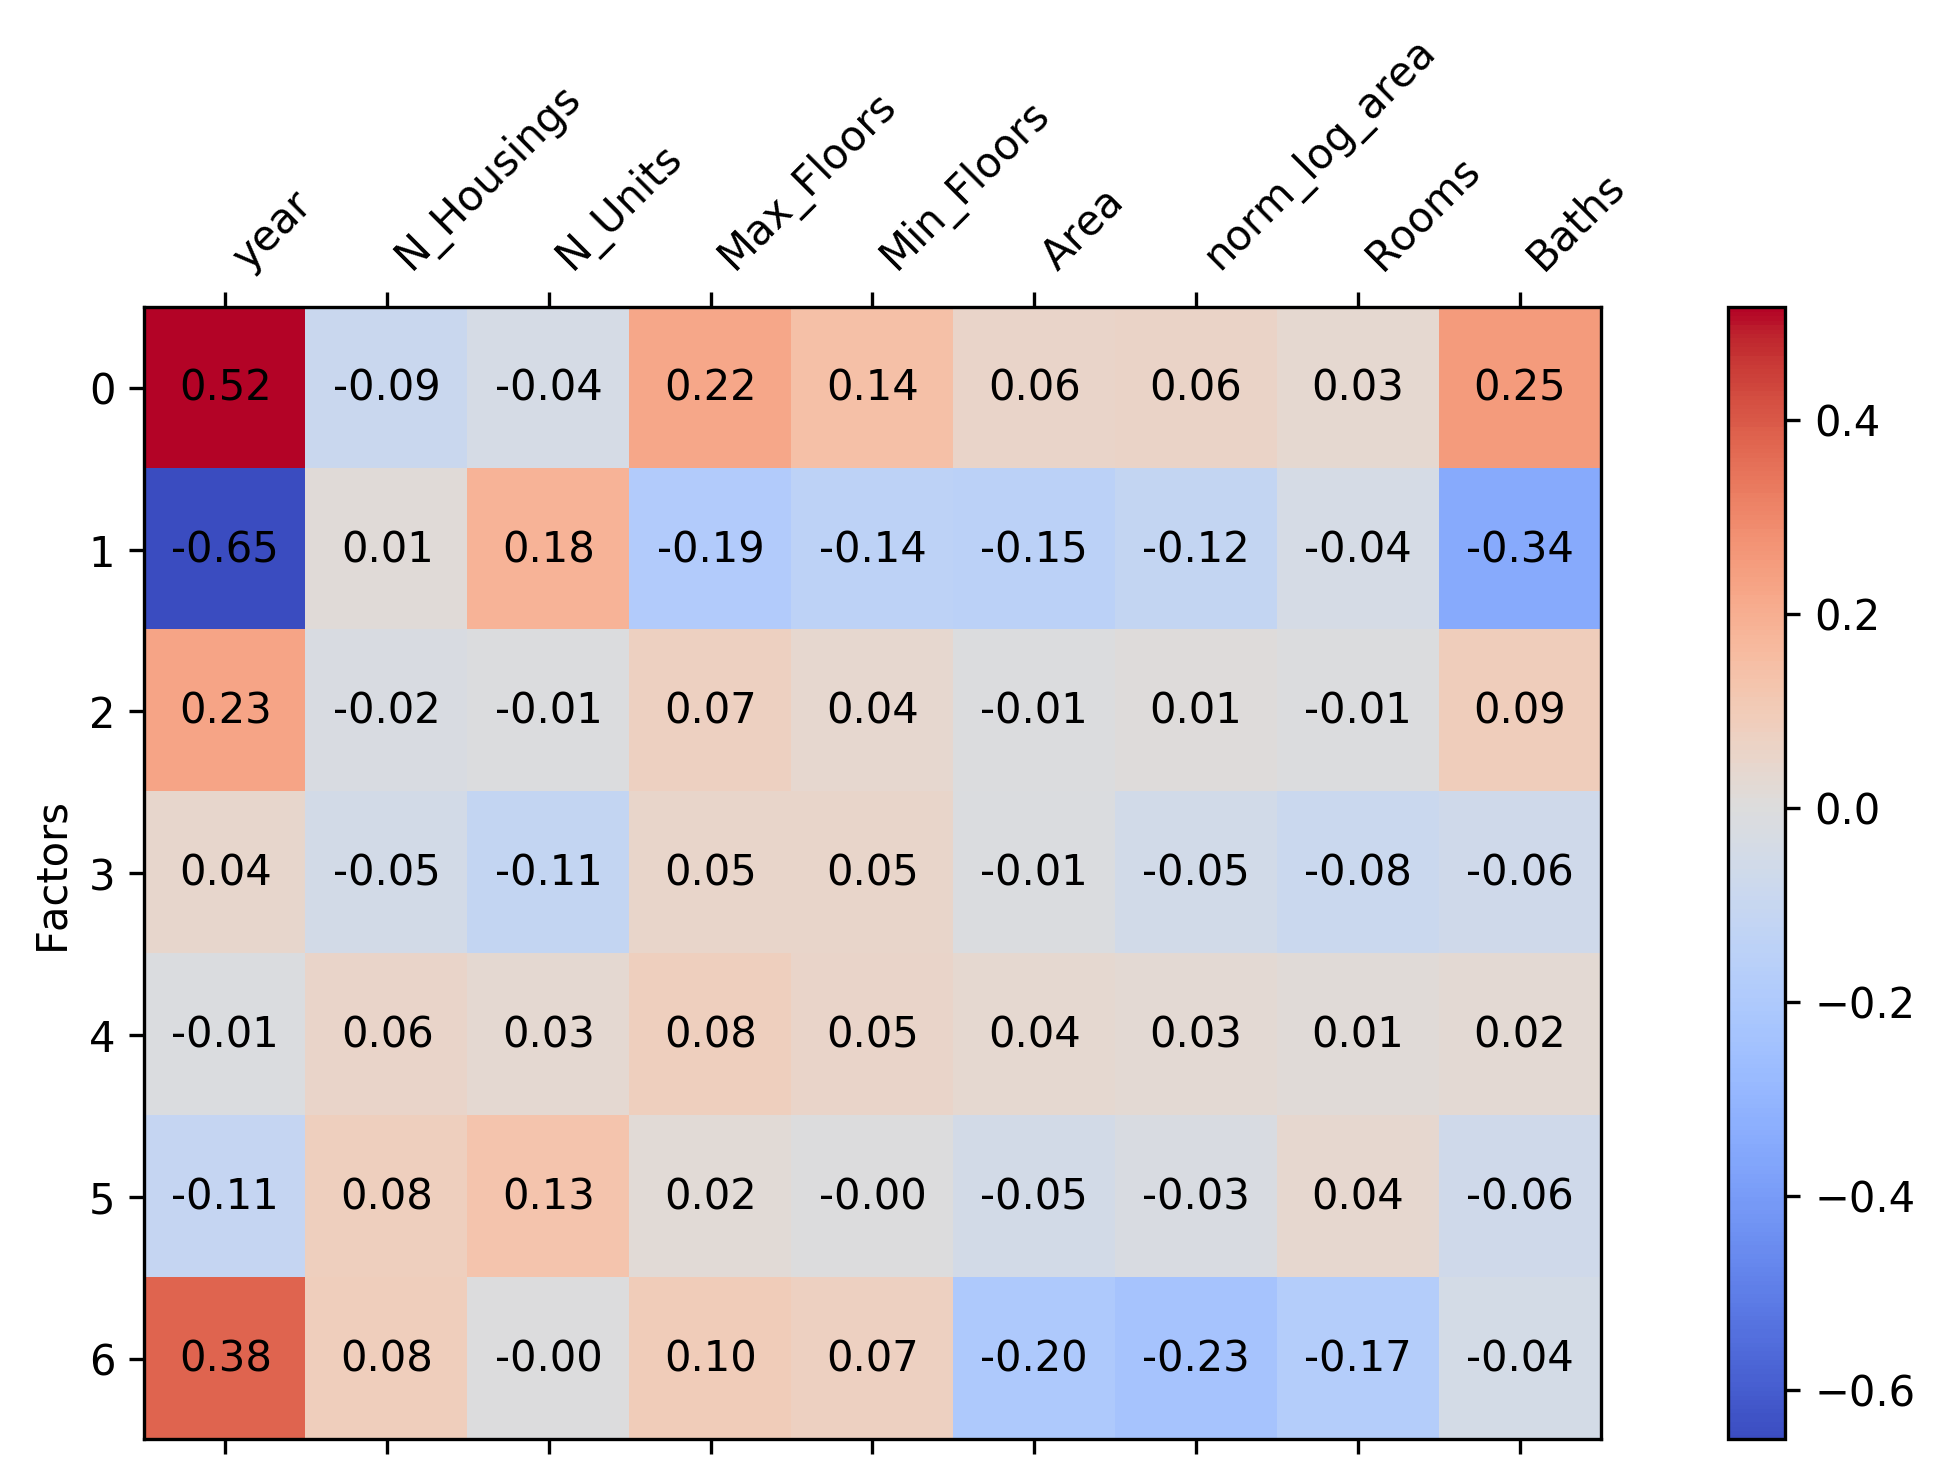

In [6]:
col_factors = ["factor{}".format(i) for i in range(7)]
col_attributes = [
    "year",
    "N_Housings",
    "N_Units",
    "Max_Floors",
    "Min_Floors",
    "Area",
    "norm_log_area",
    "Rooms",
    "Baths",
]

# for factor in col_factors:
#     print(factor)
#     print(df[col_attributes].corrwith(df[factor]))
corr = df.corr()

fig = plt.figure(figsize=(11, 5), dpi=300)
ax = plt.gca()
im = ax.matshow(
    corr.loc[col_factors, col_attributes], cmap="coolwarm", norm=DivergingNorm(0)
)

fig.colorbar(im)

ax.set_ylabel("Factors")

ax.set_xticks(range(len(col_attributes)))
texts = ax.set_xticklabels(col_attributes)
[text.set_rotation(45) for text in texts]
[text.set_ha("left") for text in texts]

for (r, c), value in np.ndenumerate(corr.loc[col_factors, col_attributes]):
    ax.text(c, r, "{:0.2f}".format(value), ha="center", va="center")

plt.show()

In [7]:
corr_pixel = pd.concat([df[["year"] + col_factors], df_pixel], axis=1).corr()
corr_pixel

year  factor0  factor1  factor2  factor3  factor4  factor5  \
year           1.000    0.516   -0.651    0.228    0.045   -0.011   -0.111   
factor0        0.516    1.000   -0.000   -0.000   -0.000    0.000    0.000   
factor1       -0.651   -0.000    1.000    0.000   -0.000   -0.000   -0.000   
factor2        0.228   -0.000    0.000    1.000    0.000   -0.000    0.000   
factor3        0.045   -0.000   -0.000    0.000    1.000   -0.000   -0.000   
factor4       -0.011    0.000   -0.000   -0.000   -0.000    1.000   -0.000   
factor5       -0.111    0.000   -0.000    0.000   -0.000   -0.000    1.000   
factor6        0.379    0.000   -0.000    0.000   -0.000    0.000    0.000   
AREA_UNIT     -0.196   -0.047    0.170   -0.026   -0.264   -0.209    0.130   
AREA_ENTRANCE  0.229    0.058   -0.197    0.050    0.029    0.023    0.001   
AREA_LDK      -0.092    0.034    0.145   -0.044   -0.056   -0.112    0.021   
AREA_BEDROOM  -0.455   -0.242    0.324   -0.075   -0.149   -0.157    0.156   
AREA_BALCONY  -0.005    0.117    0.040    0.099   -0.261   -0.100    0.007   
AREA_BATHROOM  0.265    0.064   -0.224    0.028    0.085   -0.013   -0.053   

               factor6  AREA_UNIT  AREA_ENTRANCE  AREA_LDK  AREA_BEDROOM  \
year             0.379     -0.196          0.229    -0.092        -0.455   
factor0          0.000     -0.047          0.058     0.034        -0.242   
factor1         -0.000      0.170         -0.197     0.145         0.324   
factor2          0.000     -0.026          0.050    -0.044        -0.075   
factor3         -0.000     -0.264          0.029    -0.056        -0.149   
factor4          0.000     -0.209          0.023    -0.112        -0.157   
factor5          0.000      0.130          0.001     0.021         0.156   
factor6          1.000     -0.071          0.145     0.019        -0.203   
AREA_UNIT       -0.071      1.000          0.183     0.609         0.671   
AREA_ENTRANCE    0.145      0.183          1.000     0.289        -0.074   
AREA_LDK         0.019      0.609          0.289     1.000         0.139   
AREA_BEDROOM    -0.203      0.671         -0.074     0.139         1.000   
AREA_BALCONY    -0.148      0.466         -0.067    -0.116         0.147   
AREA_BATHROOM    0.193      0.175          0.457     0.437        -0.164   

               AREA_BALCONY  AREA_BATHROOM  
year                 -0.005          0.265  
factor0               0.117          0.064  
factor1               0.040         -0.224  
factor2               0.099          0.028  
factor3              -0.261          0.085  
factor4              -0.100         -0.013  
factor5               0.007         -0.053  
factor6              -0.148          0.193  
AREA_UNIT             0.466          0.175  
AREA_ENTRANCE        -0.067          0.457  
AREA_LDK             -0.116          0.437  
AREA_BEDROOM          0.147         -0.164  
AREA_BALCONY          1.000         -0.162  
AREA_BATHROOM        -0.162          1.000

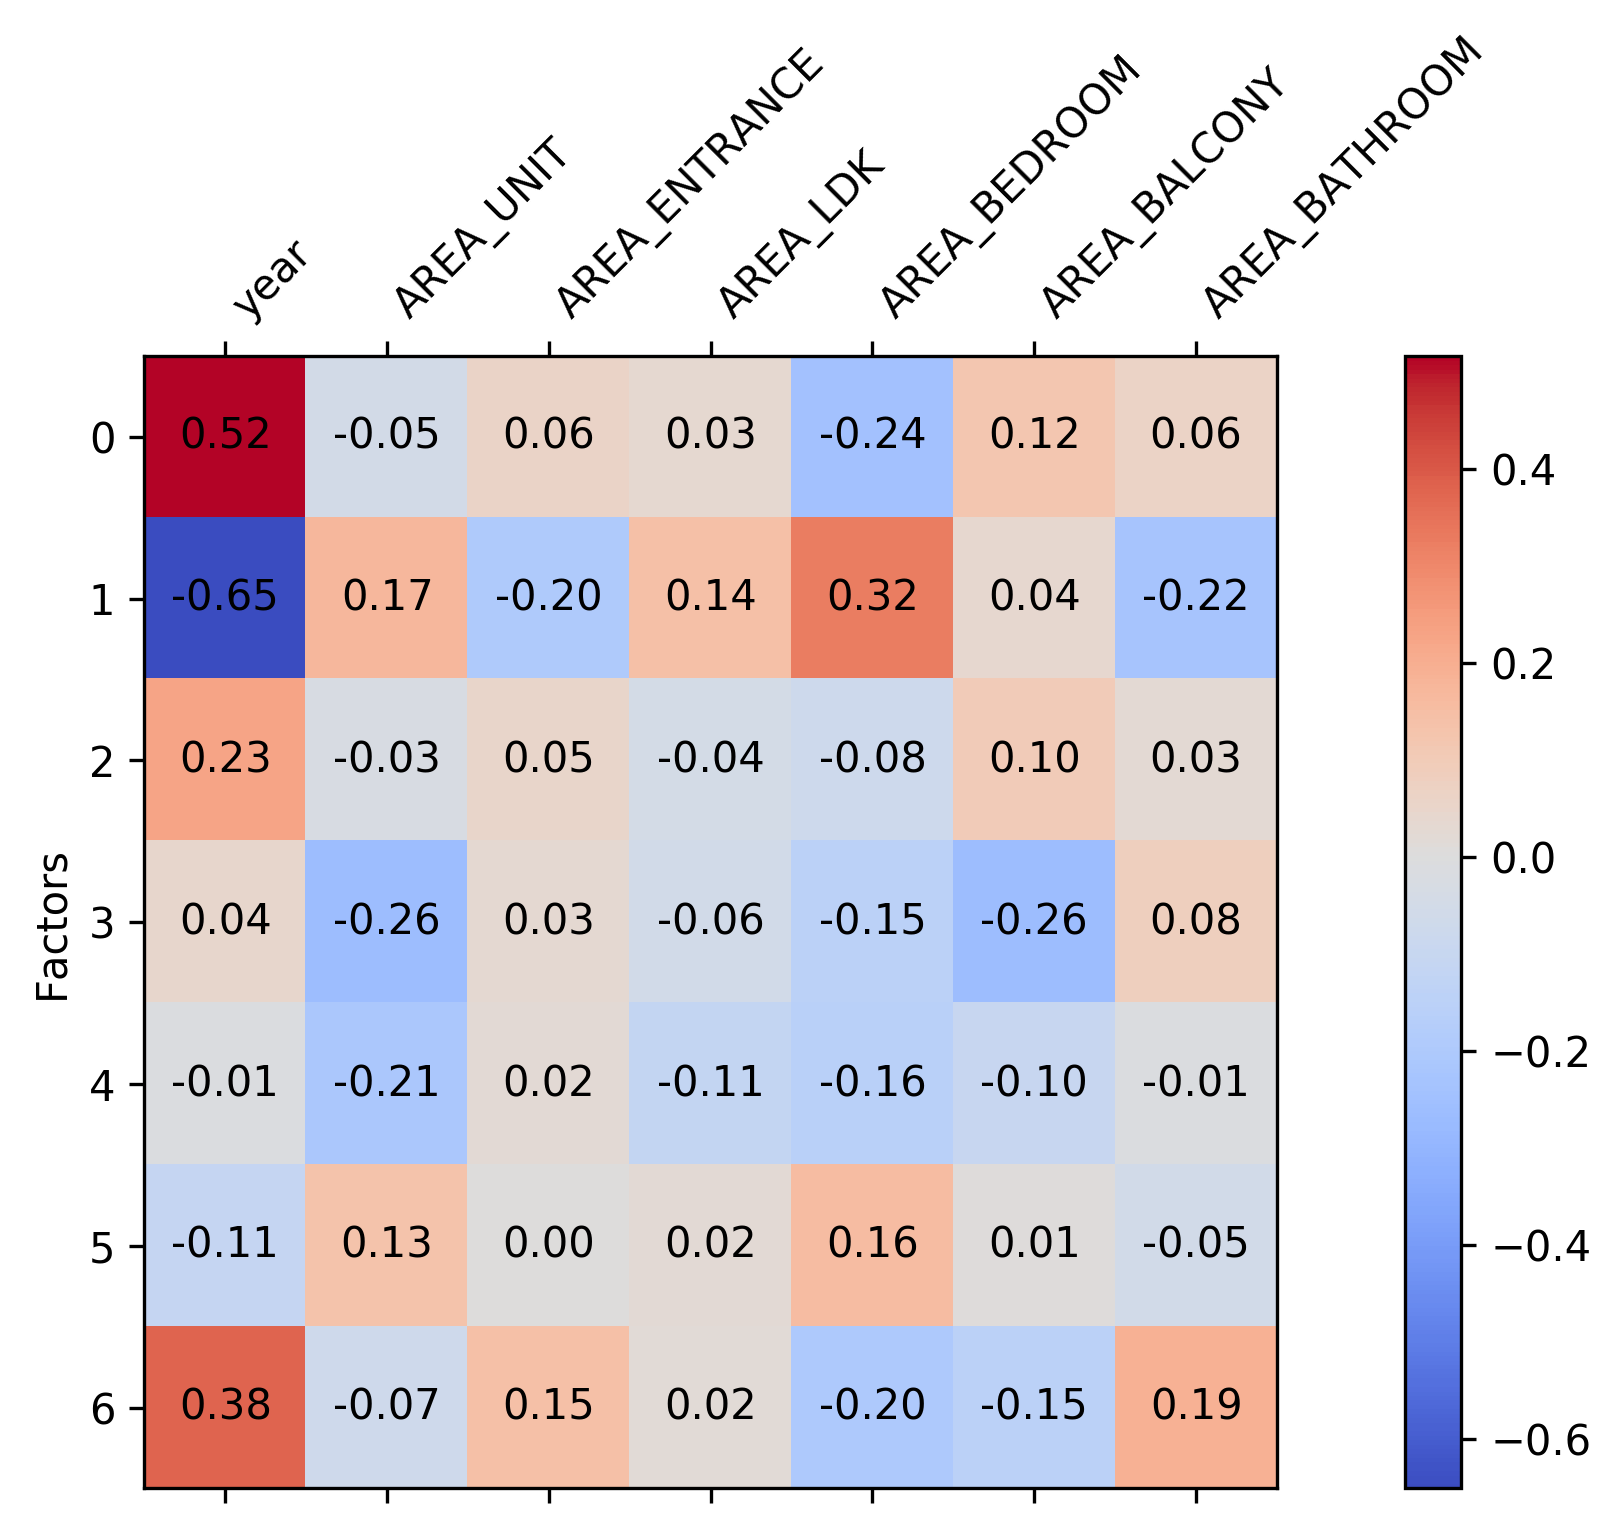

In [8]:
xcols = ["year"] + list(df_pixel.columns)

fig = plt.figure(figsize=(11, 5), dpi=300)
ax = plt.gca()
im = ax.matshow(
    corr_pixel.loc[col_factors, xcols], cmap="coolwarm", norm=DivergingNorm(0)
)

fig.colorbar(im)

ax.set_ylabel("Factors")

ax.set_xticks(range(len(xcols)))
texts = ax.set_xticklabels(xcols)
[text.set_rotation(45) for text in texts]
[text.set_ha("left") for text in texts]

for (r, c), value in np.ndenumerate(corr_pixel.loc[col_factors, xcols]):
    ax.text(c, r, "{:0.2f}".format(value), ha="center", va="center")

plt.show()

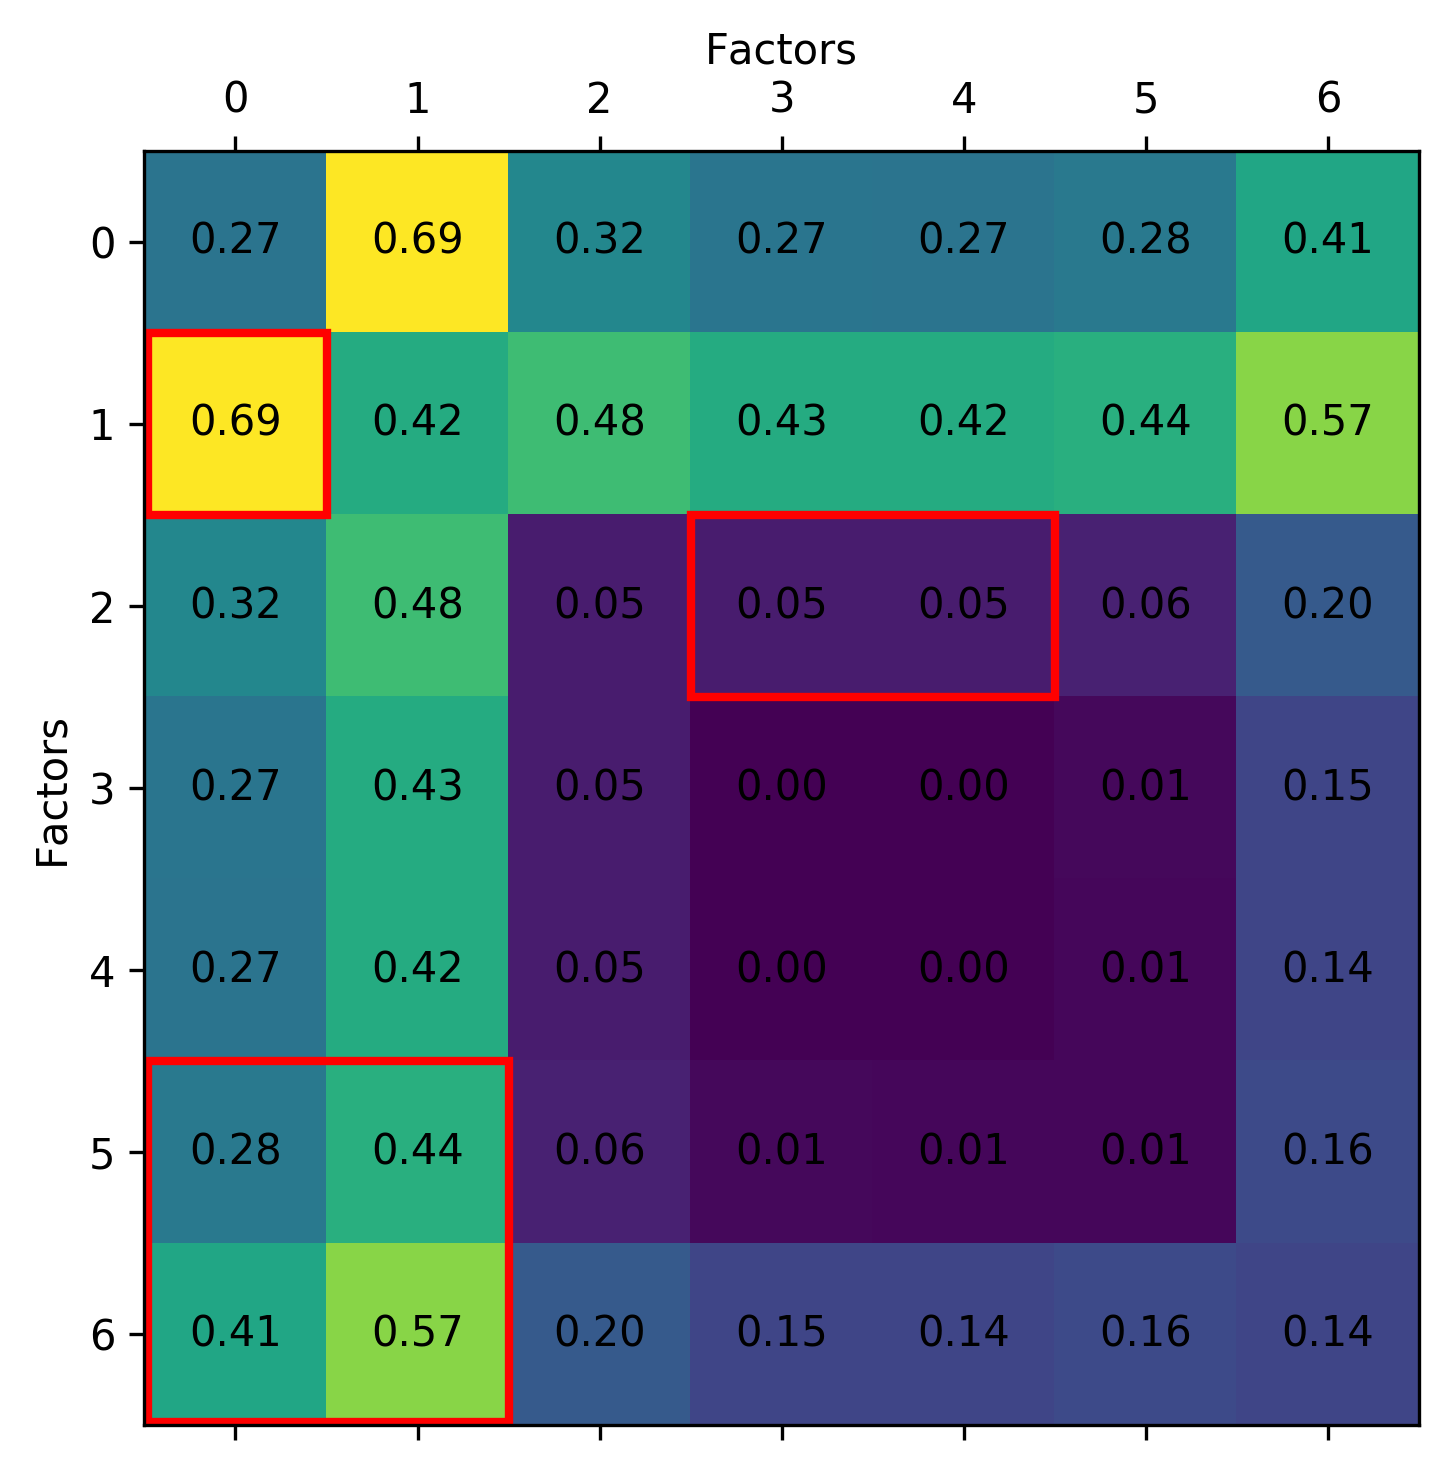

In [136]:
regr_scores = np.zeros((7, 7))

y = df["year"]

for i in range(7):
    for j in range(7):
        X = df[[f"factor{i}", f"factor{j}"]]
        regr = LinearRegression().fit(X, y)
        regr_scores[i, j] = regr.score(X, y)
regr_scores

fig = plt.figure(figsize=(11, 5), dpi=300, tight_layout=True)
ax = plt.gca()
im = ax.matshow(regr_scores)

ax.xaxis.set_label_position("top")
ax.set_xlabel("Factors")
ax.set_ylabel("Factors")

for (r, c), value in np.ndenumerate(regr_scores):
    ax.text(c, r, "{:0.2f}".format(value), ha="center", va="center")

rect01 = patches.Rectangle((-0.48, 0.5), 0.98, 1, lw=2, edgecolor="r", fc="none")
rect0156 = patches.Rectangle((-0.48, 4.5), 1.98, 1.98, lw=2, edgecolor="r", fc="none")
rect234 = patches.Rectangle((2.5, 1.5), 2, 1, lw=2, edgecolor="r", fc="none")

[ax.add_patch(p) for p in [rect01, rect0156, rect234]]

In [32]:
def plot_hexbin_equal(
    x,
    y,
    C=None,
    reduce_C_function=np.mean,
    bins=None,
    xlabel=None,
    ylabel=None,
    gridscale=None,
    n_grid=400,
    mincnt=10,
    cmap="viridis",
    norm=None,
    vmin=None,
    vmax=None,
    ax=None,
    figsize=(11, 15),
):
    if xlabel is None:
        xlabel = x.name
    if ylabel is None:
        ylabel = y.name

    if ax is None:
        fig = plt.figure(figsize=figsize, dpi=300)
        ax = fig.gca()

    if C is not None:
        if vmin is None:
            vmin = np.amin(C)
        if vmax is None:
            vmax = np.amax(C)

    xlim, ylim = (np.quantile(a, (0.005, 0.995)) for a in [x, y])
    if gridscale is None:
        gridscale = sqrt((xlim[1] - xlim[0]) * (ylim[1] - ylim[0]) / n_grid)
    gridsize = (
        int((xlim[1] - xlim[0]) / gridscale),
        int((ylim[1] - ylim[0]) / (gridscale * sqrt(3))),
    )
    poly = ax.hexbin(
        x,
        y,
        C,
        reduce_C_function=reduce_C_function,
        gridsize=gridsize,
        bins=bins,
        extent=(*xlim, *ylim),
        mincnt=mincnt,
        cmap=cmap,
        norm=norm,
        vmin=vmin,
        vmax=vmax,
    )

    #     plt.colorbar(poly, ax=ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect("equal")

    return poly

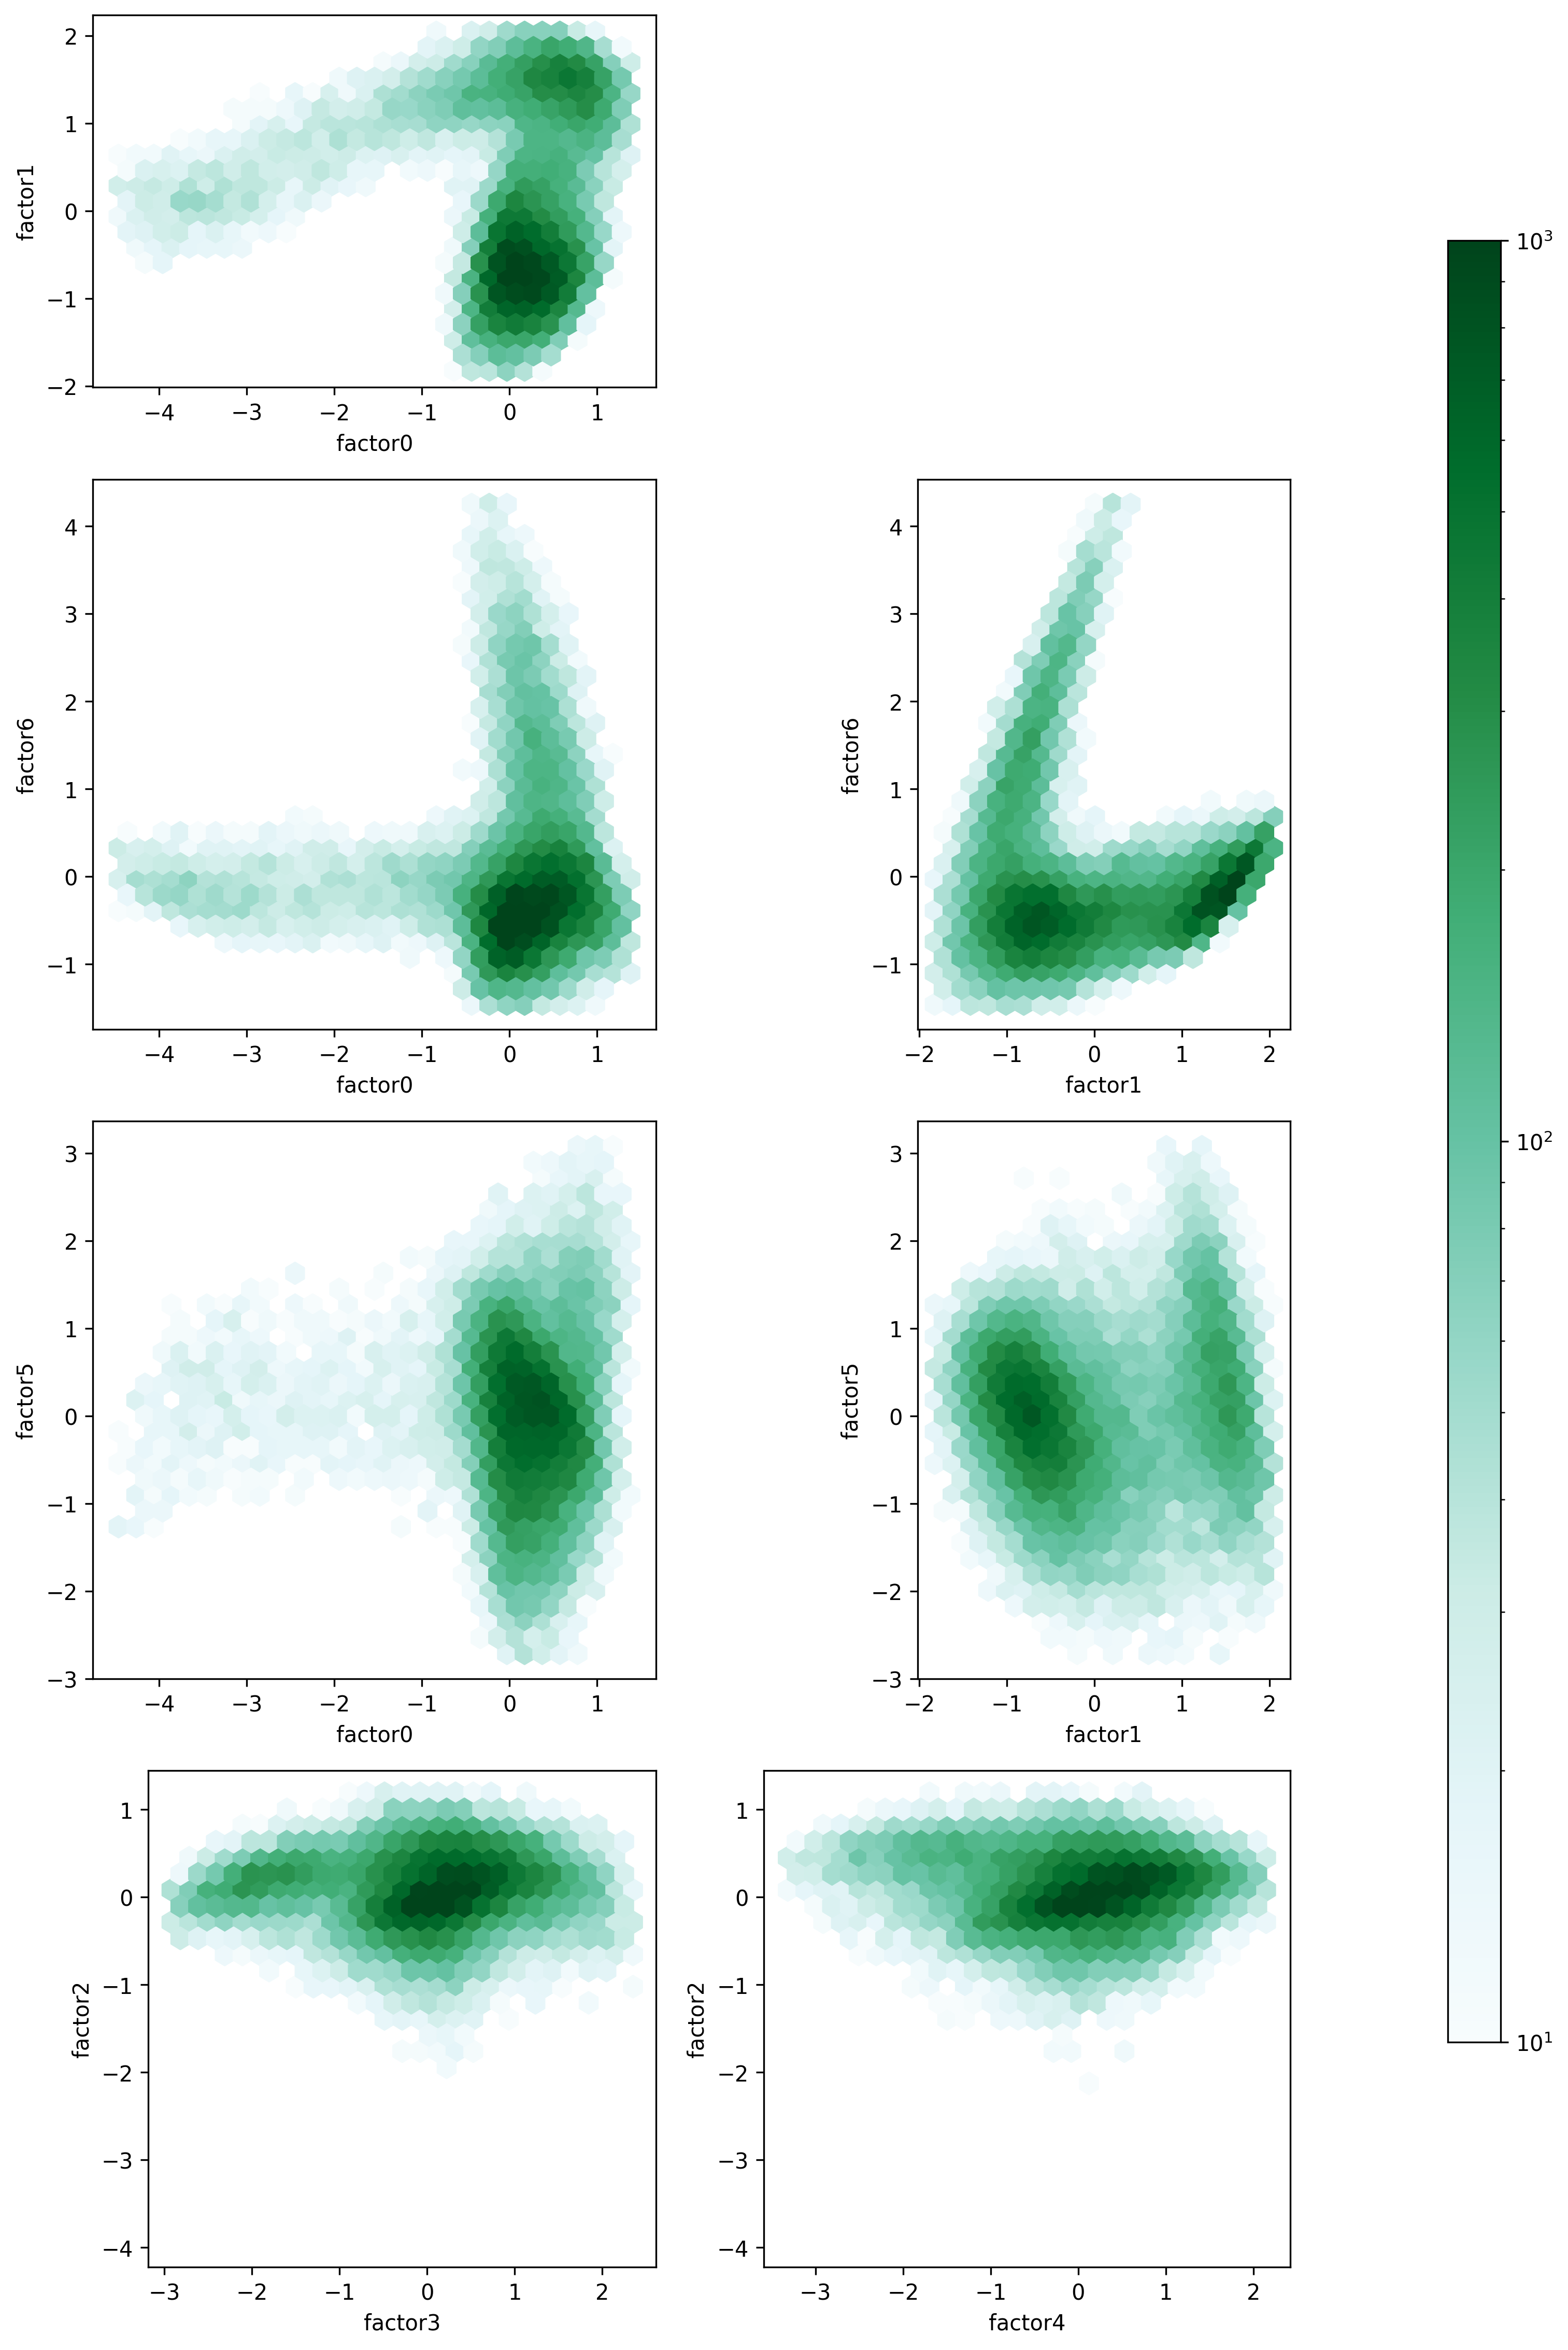

In [116]:
lims = [np.quantile(df[f], (0.005, 0.995)) for f in [f"factor{i}" for i in range(7)]]

heights = [np.diff(lims[i])[0] for i in [1, 6, 5, 2]]
widths = [np.diff(lims[i])[0] for i in [0, 1]]

fig = plt.figure(figsize=(11, 15), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(4, 2, height_ratios=heights, width_ratios=widths)


ax01 = fig.add_subplot(gs[0, 0], aspect="equal")
ax06 = fig.add_subplot(gs[1, 0], aspect="equal")
ax16 = fig.add_subplot(gs[1, 1], aspect="equal")


ax05 = fig.add_subplot(gs[2, 0], aspect="equal")
ax15 = fig.add_subplot(gs[2, 1], aspect="equal")
ax32 = fig.add_subplot(gs[3, 0], aspect="equal")
ax42 = fig.add_subplot(gs[3, 1], aspect="equal")


plots = [
    (ax06, "factor0", "factor6"),
    (ax01, "factor0", "factor1"),
    (ax16, "factor1", "factor6"),
    (ax05, "factor0", "factor5"),
    (ax15, "factor1", "factor5"),
    (ax32, "factor3", "factor2"),
    (ax42, "factor4", "factor2"),
]

for ax, x, y in plots:
    plot_hexbin_equal(
        df[x],
        df[y],
        cmap="BuGn",
        bins="log",
        vmax=1000,
        mincnt=10,
        gridscale=0.2,
        ax=ax,
    )

fig.colorbar(ax01.collections[0], ax=[ax for ax, _, _ in plots], pad=0.1, shrink=0.8)
# fig.tight_layout()

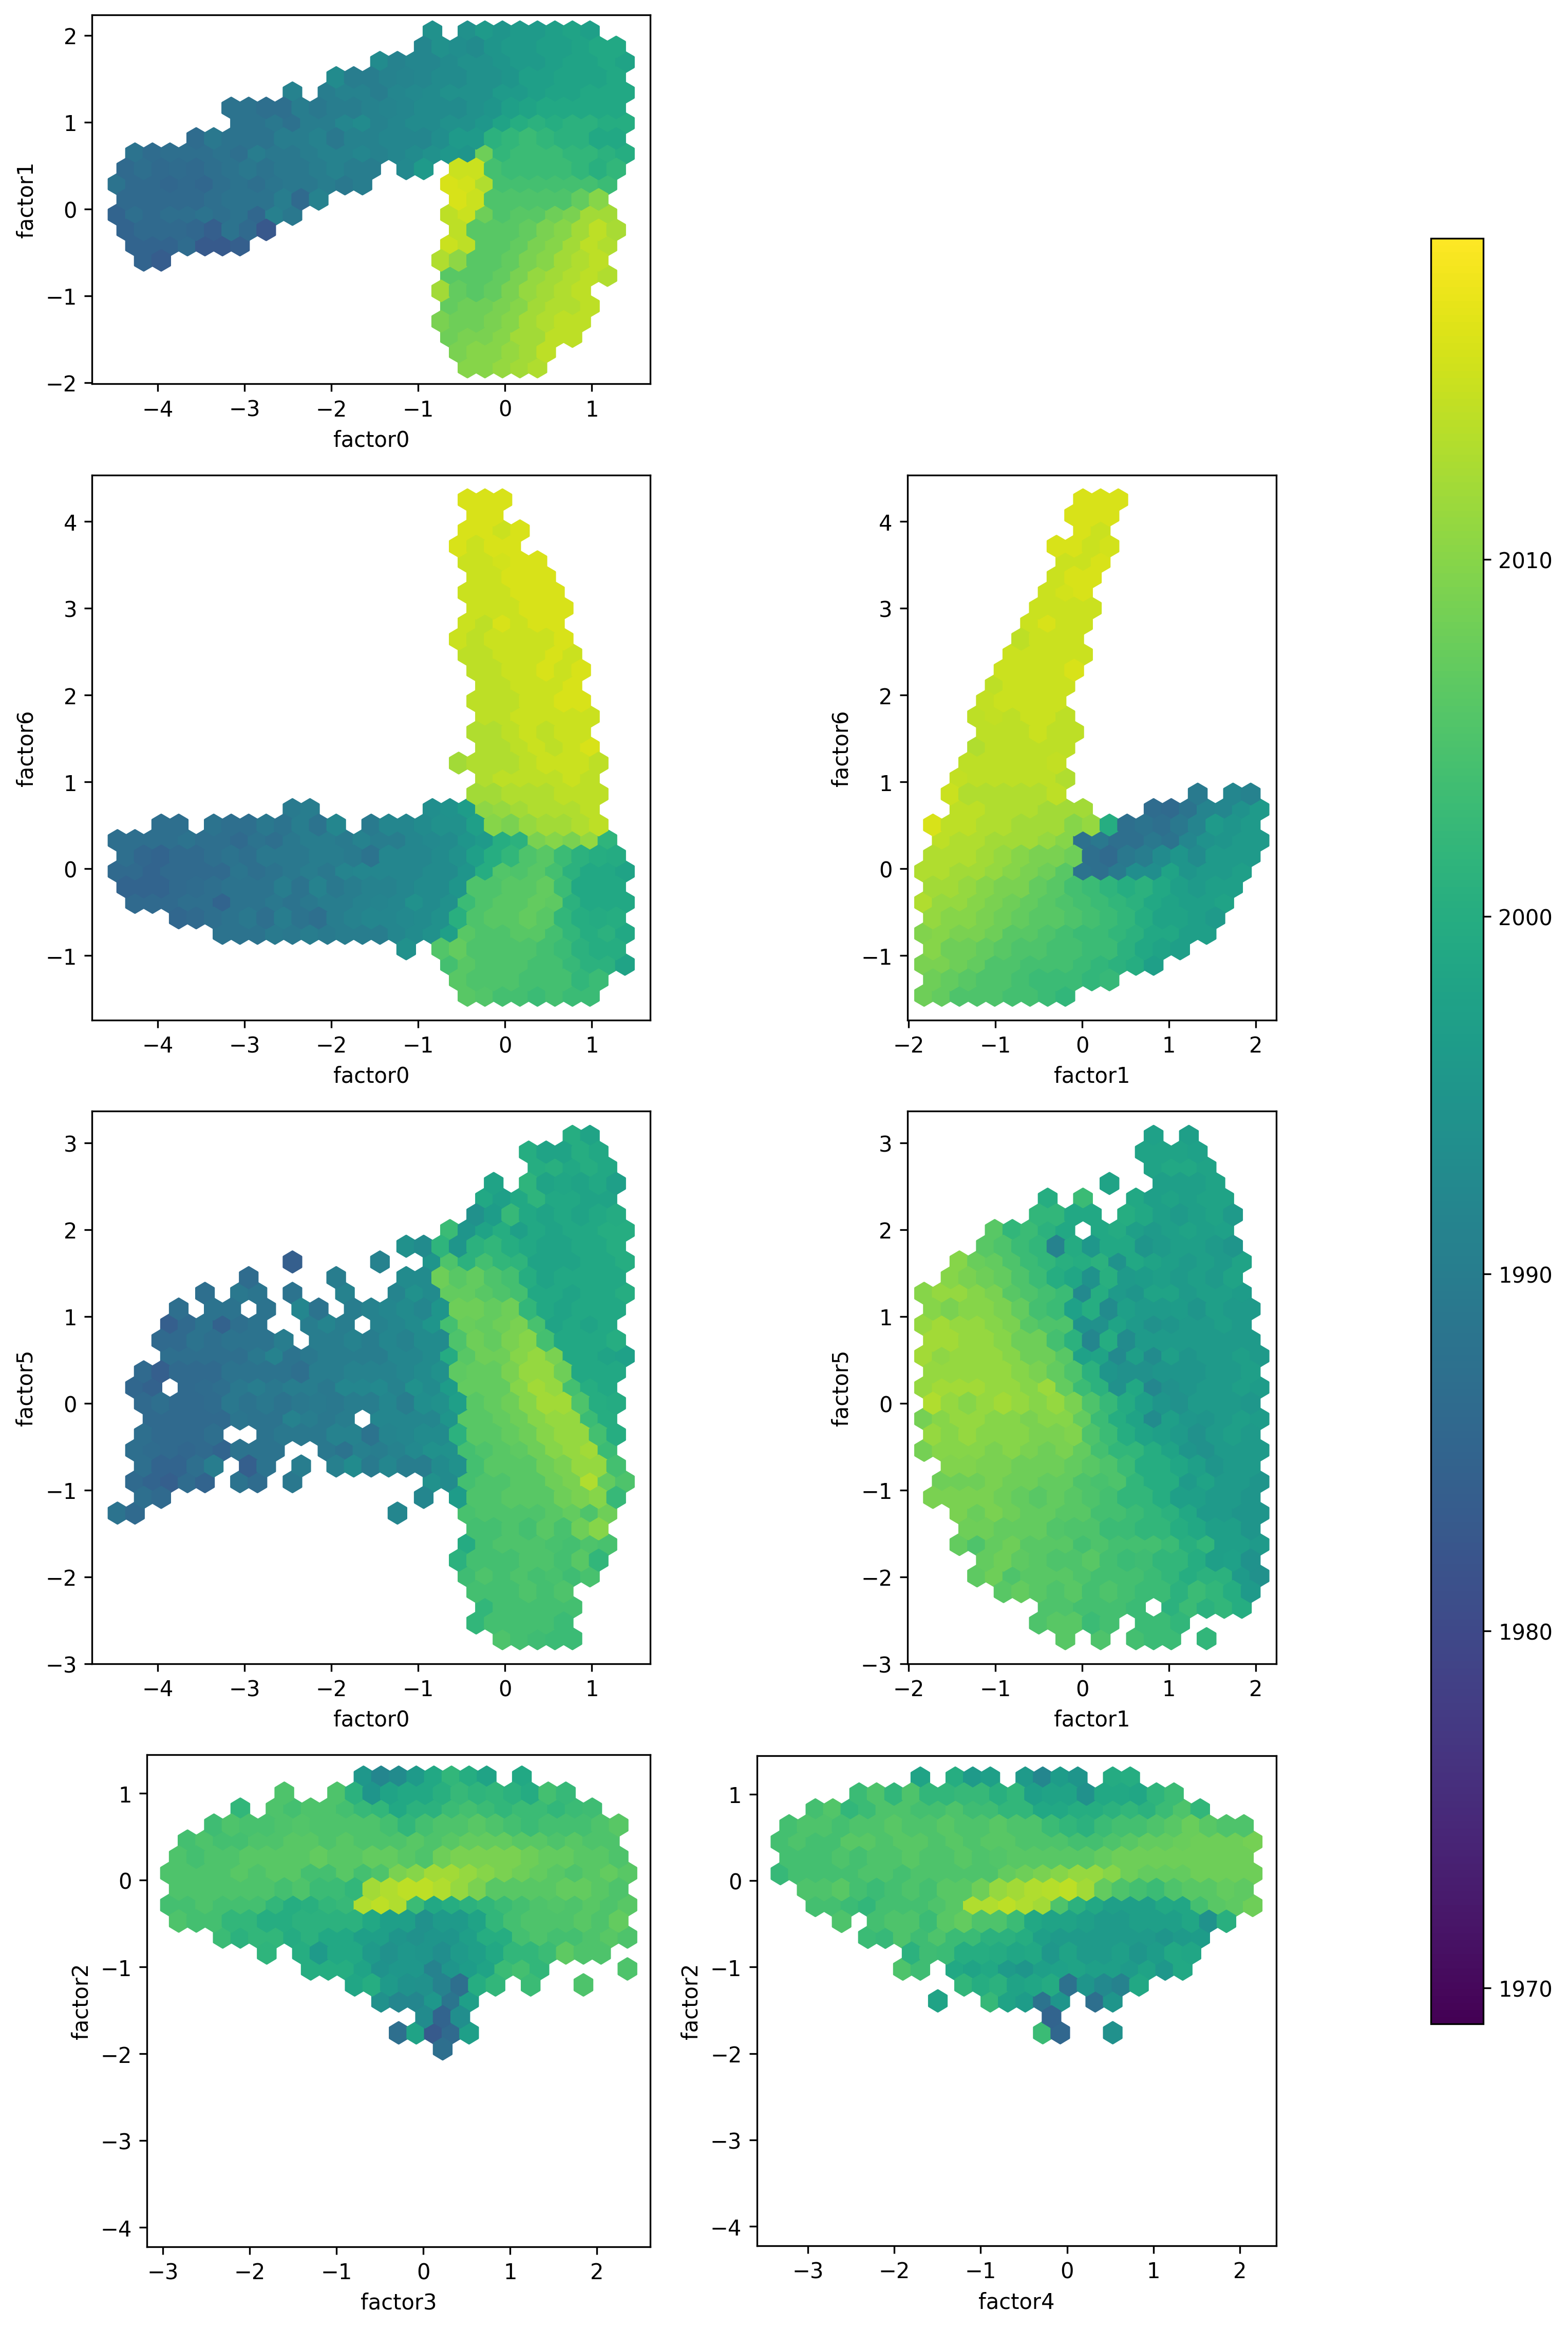

In [137]:
lims = [np.quantile(df[f], (0.005, 0.995)) for f in [f"factor{i}" for i in range(7)]]

heights = [np.diff(lims[i])[0] for i in [1, 6, 5, 2]]
widths = [np.diff(lims[i])[0] for i in [0, 1]]

fig = plt.figure(figsize=(11, 15), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(4, 2, height_ratios=heights, width_ratios=widths)


ax01 = fig.add_subplot(gs[0, 0], aspect="equal")
ax06 = fig.add_subplot(gs[1, 0], aspect="equal")
ax16 = fig.add_subplot(gs[1, 1], aspect="equal")


ax05 = fig.add_subplot(gs[2, 0], aspect="equal")
ax15 = fig.add_subplot(gs[2, 1], aspect="equal")
ax32 = fig.add_subplot(gs[3, 0], aspect="equal")
ax42 = fig.add_subplot(gs[3, 1], aspect="equal")


plots = [
    (ax06, "factor0", "factor6"),
    (ax01, "factor0", "factor1"),
    (ax16, "factor1", "factor6"),
    (ax05, "factor0", "factor5"),
    (ax15, "factor1", "factor5"),
    (ax32, "factor3", "factor2"),
    (ax42, "factor4", "factor2"),
]

for ax, x, y in plots:
    plot_hexbin_equal(
        df[x], df[y], df["year"], np.median, mincnt=10, gridscale=0.2, ax=ax
    )

fig.colorbar(ax01.collections[0], ax=[ax for ax, _, _ in plots], pad=0.1, shrink=0.8)

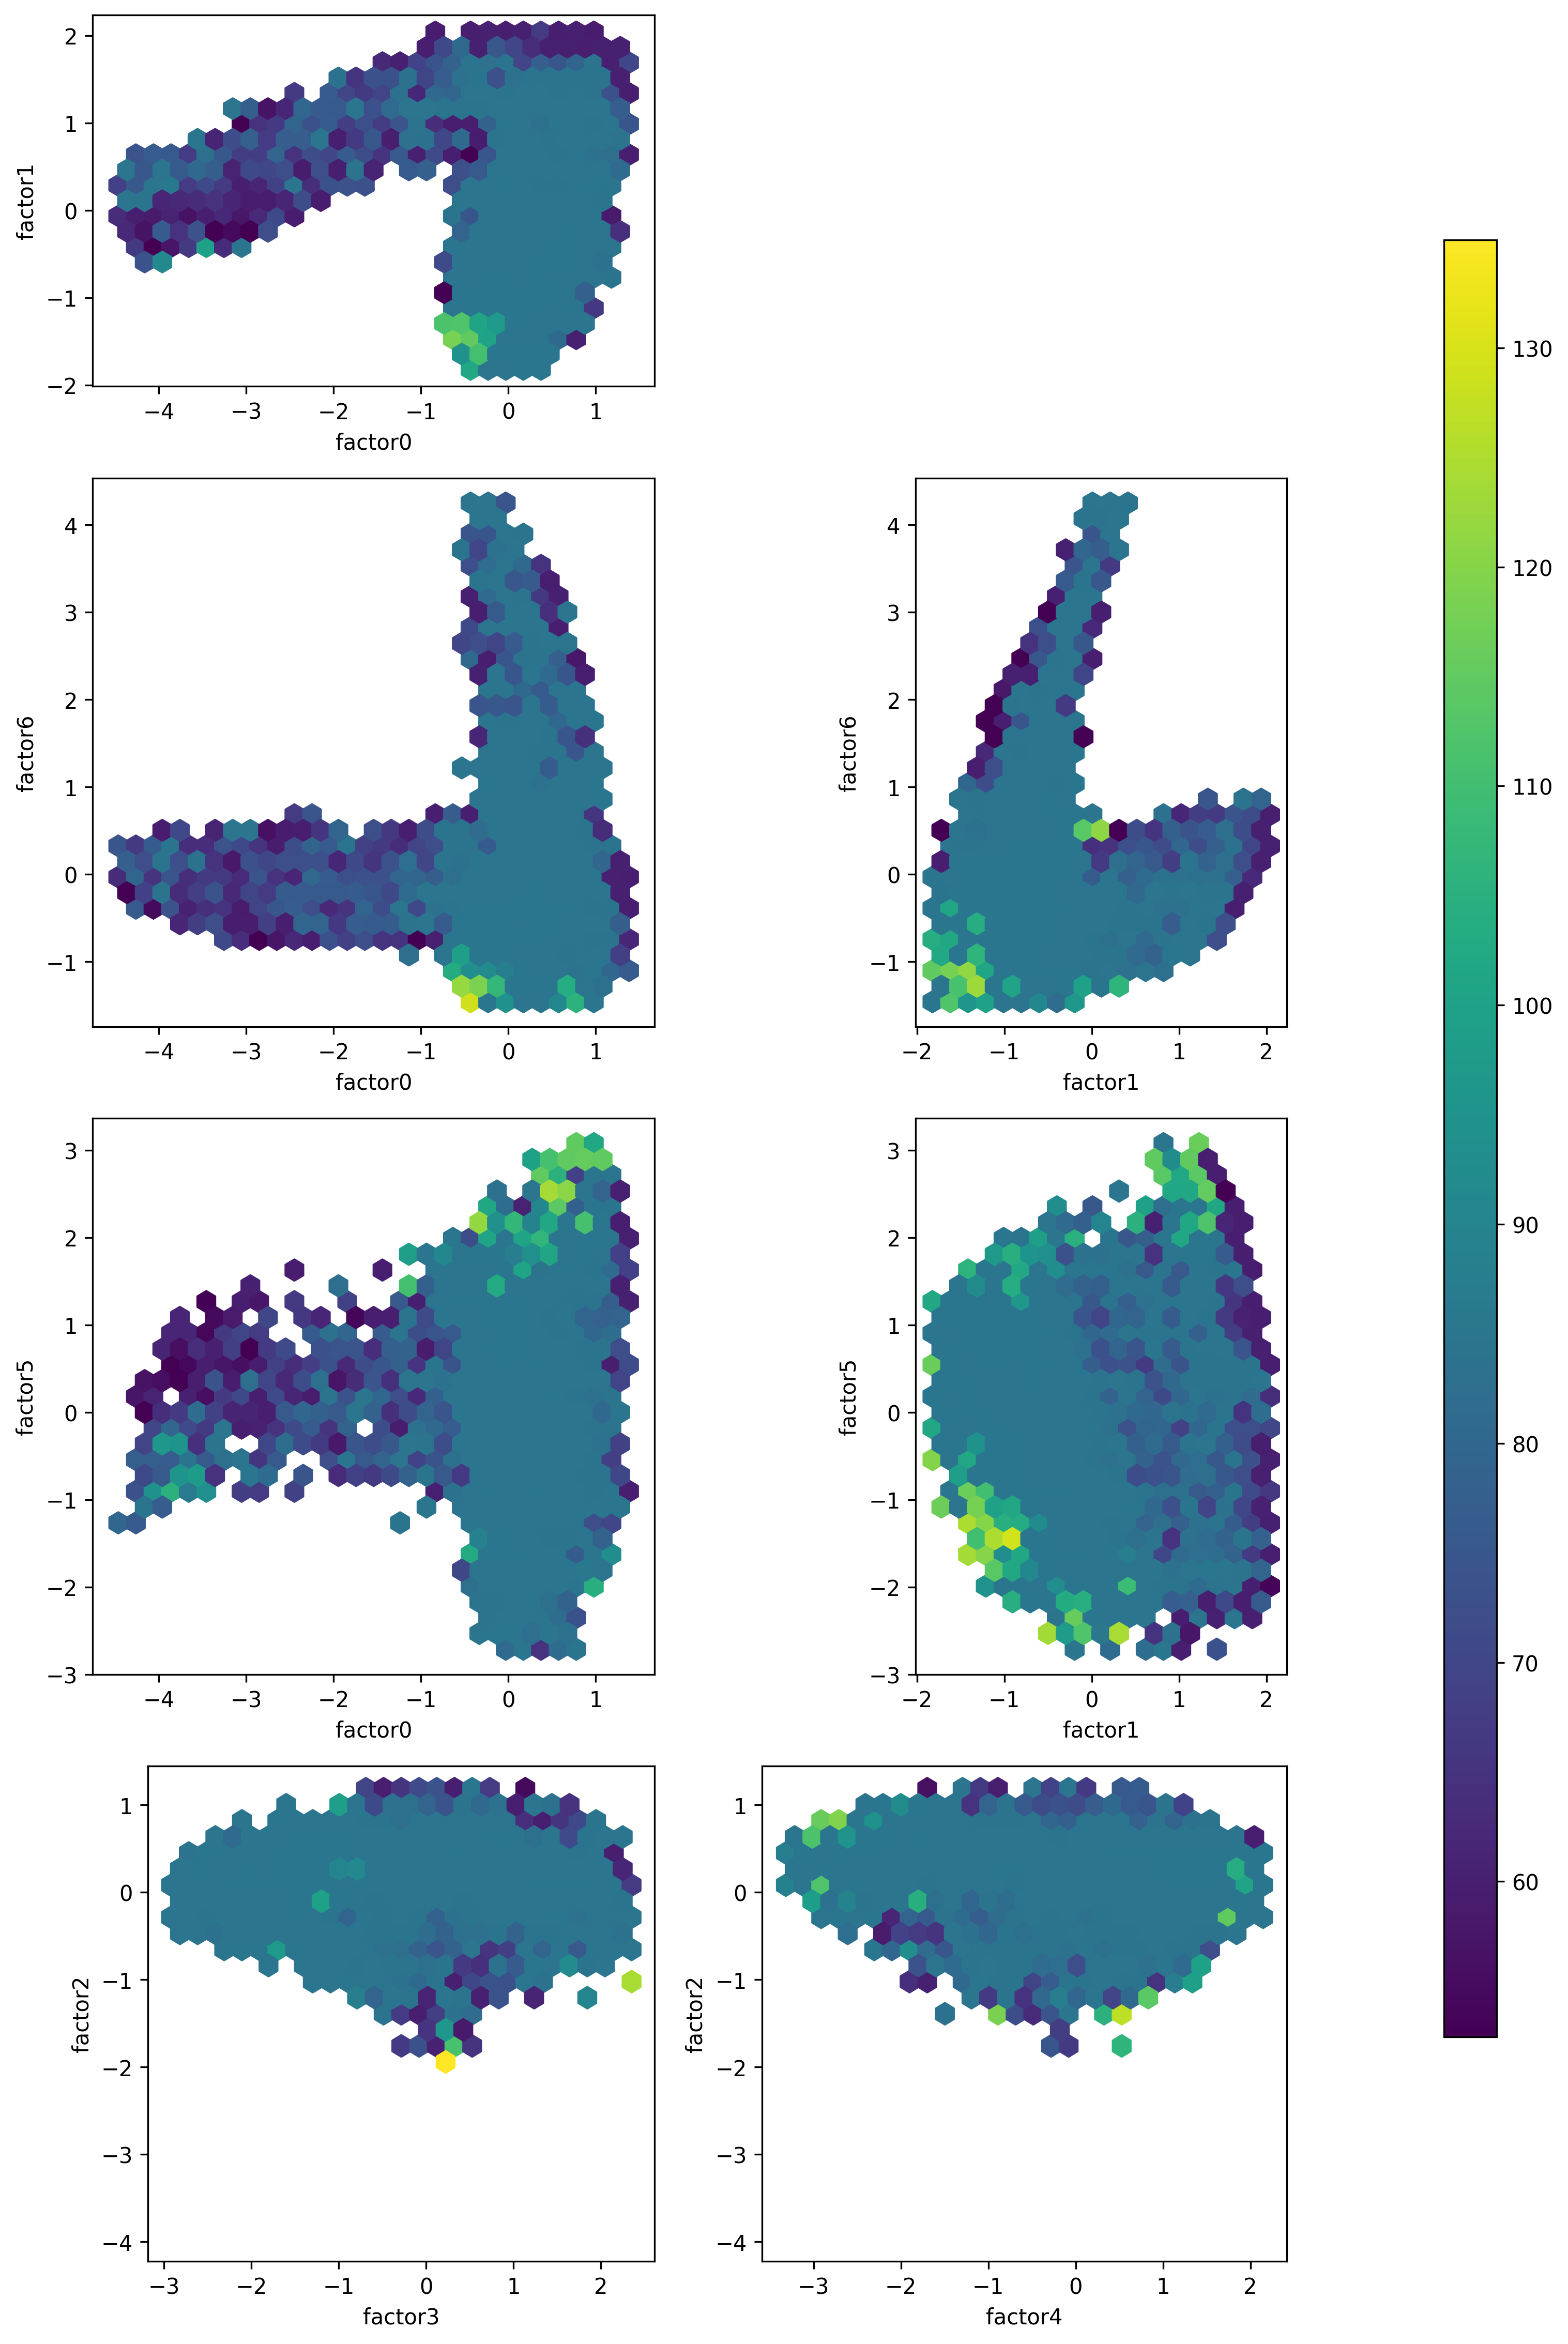

In [154]:
lims = [np.quantile(df[f], (0.005, 0.995)) for f in [f"factor{i}" for i in range(7)]]

heights = [np.diff(lims[i])[0] for i in [1, 6, 5, 2]]
widths = [np.diff(lims[i])[0] for i in [0, 1]]
fig = plt.figure(figsize=(11, 15), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(4, 2, height_ratios=heights, width_ratios=widths)

# heights = [np.diff(lims[i])[0] for i in [1, 6]]
# widths = [np.diff(lims[i])[0] for i in [0, 1]]
# fig = plt.figure(figsize=(11, 7), dpi=300, constrained_layout=True)
# gs = fig.add_gridspec(2, 2, height_ratios=heights, width_ratios=widths)


ax01 = fig.add_subplot(gs[0, 0], aspect="equal")
ax06 = fig.add_subplot(gs[1, 0], aspect="equal")
ax16 = fig.add_subplot(gs[1, 1], aspect="equal")

ax05 = fig.add_subplot(gs[2, 0], aspect="equal")
ax15 = fig.add_subplot(gs[2, 1], aspect="equal")
ax32 = fig.add_subplot(gs[3, 0], aspect="equal")
ax42 = fig.add_subplot(gs[3, 1], aspect="equal")

plots = [
    (ax06, "factor0", "factor6"),
    (ax01, "factor0", "factor1"),
    (ax16, "factor1", "factor6"),
    (ax05, "factor0", "factor5"),
    (ax15, "factor1", "factor5"),
    (ax32, "factor3", "factor2"),
    (ax42, "factor4", "factor2"),
]

C = df["Area"]
vmin, vmax = np.quantile(C, (0.1, 0.9))

for ax, x, y in plots:
    plot_hexbin_equal(
        df[x],
        df[y],
        C,
        np.median,
        vmin=vmin,
        vmax=vmax,
        mincnt=10,
        gridscale=0.2,
        ax=ax,
    )

fig.colorbar(ax01.collections[0], ax=[ax for ax, _, _ in plots], pad=0.1, shrink=0.8)
# fig.tight_layout()

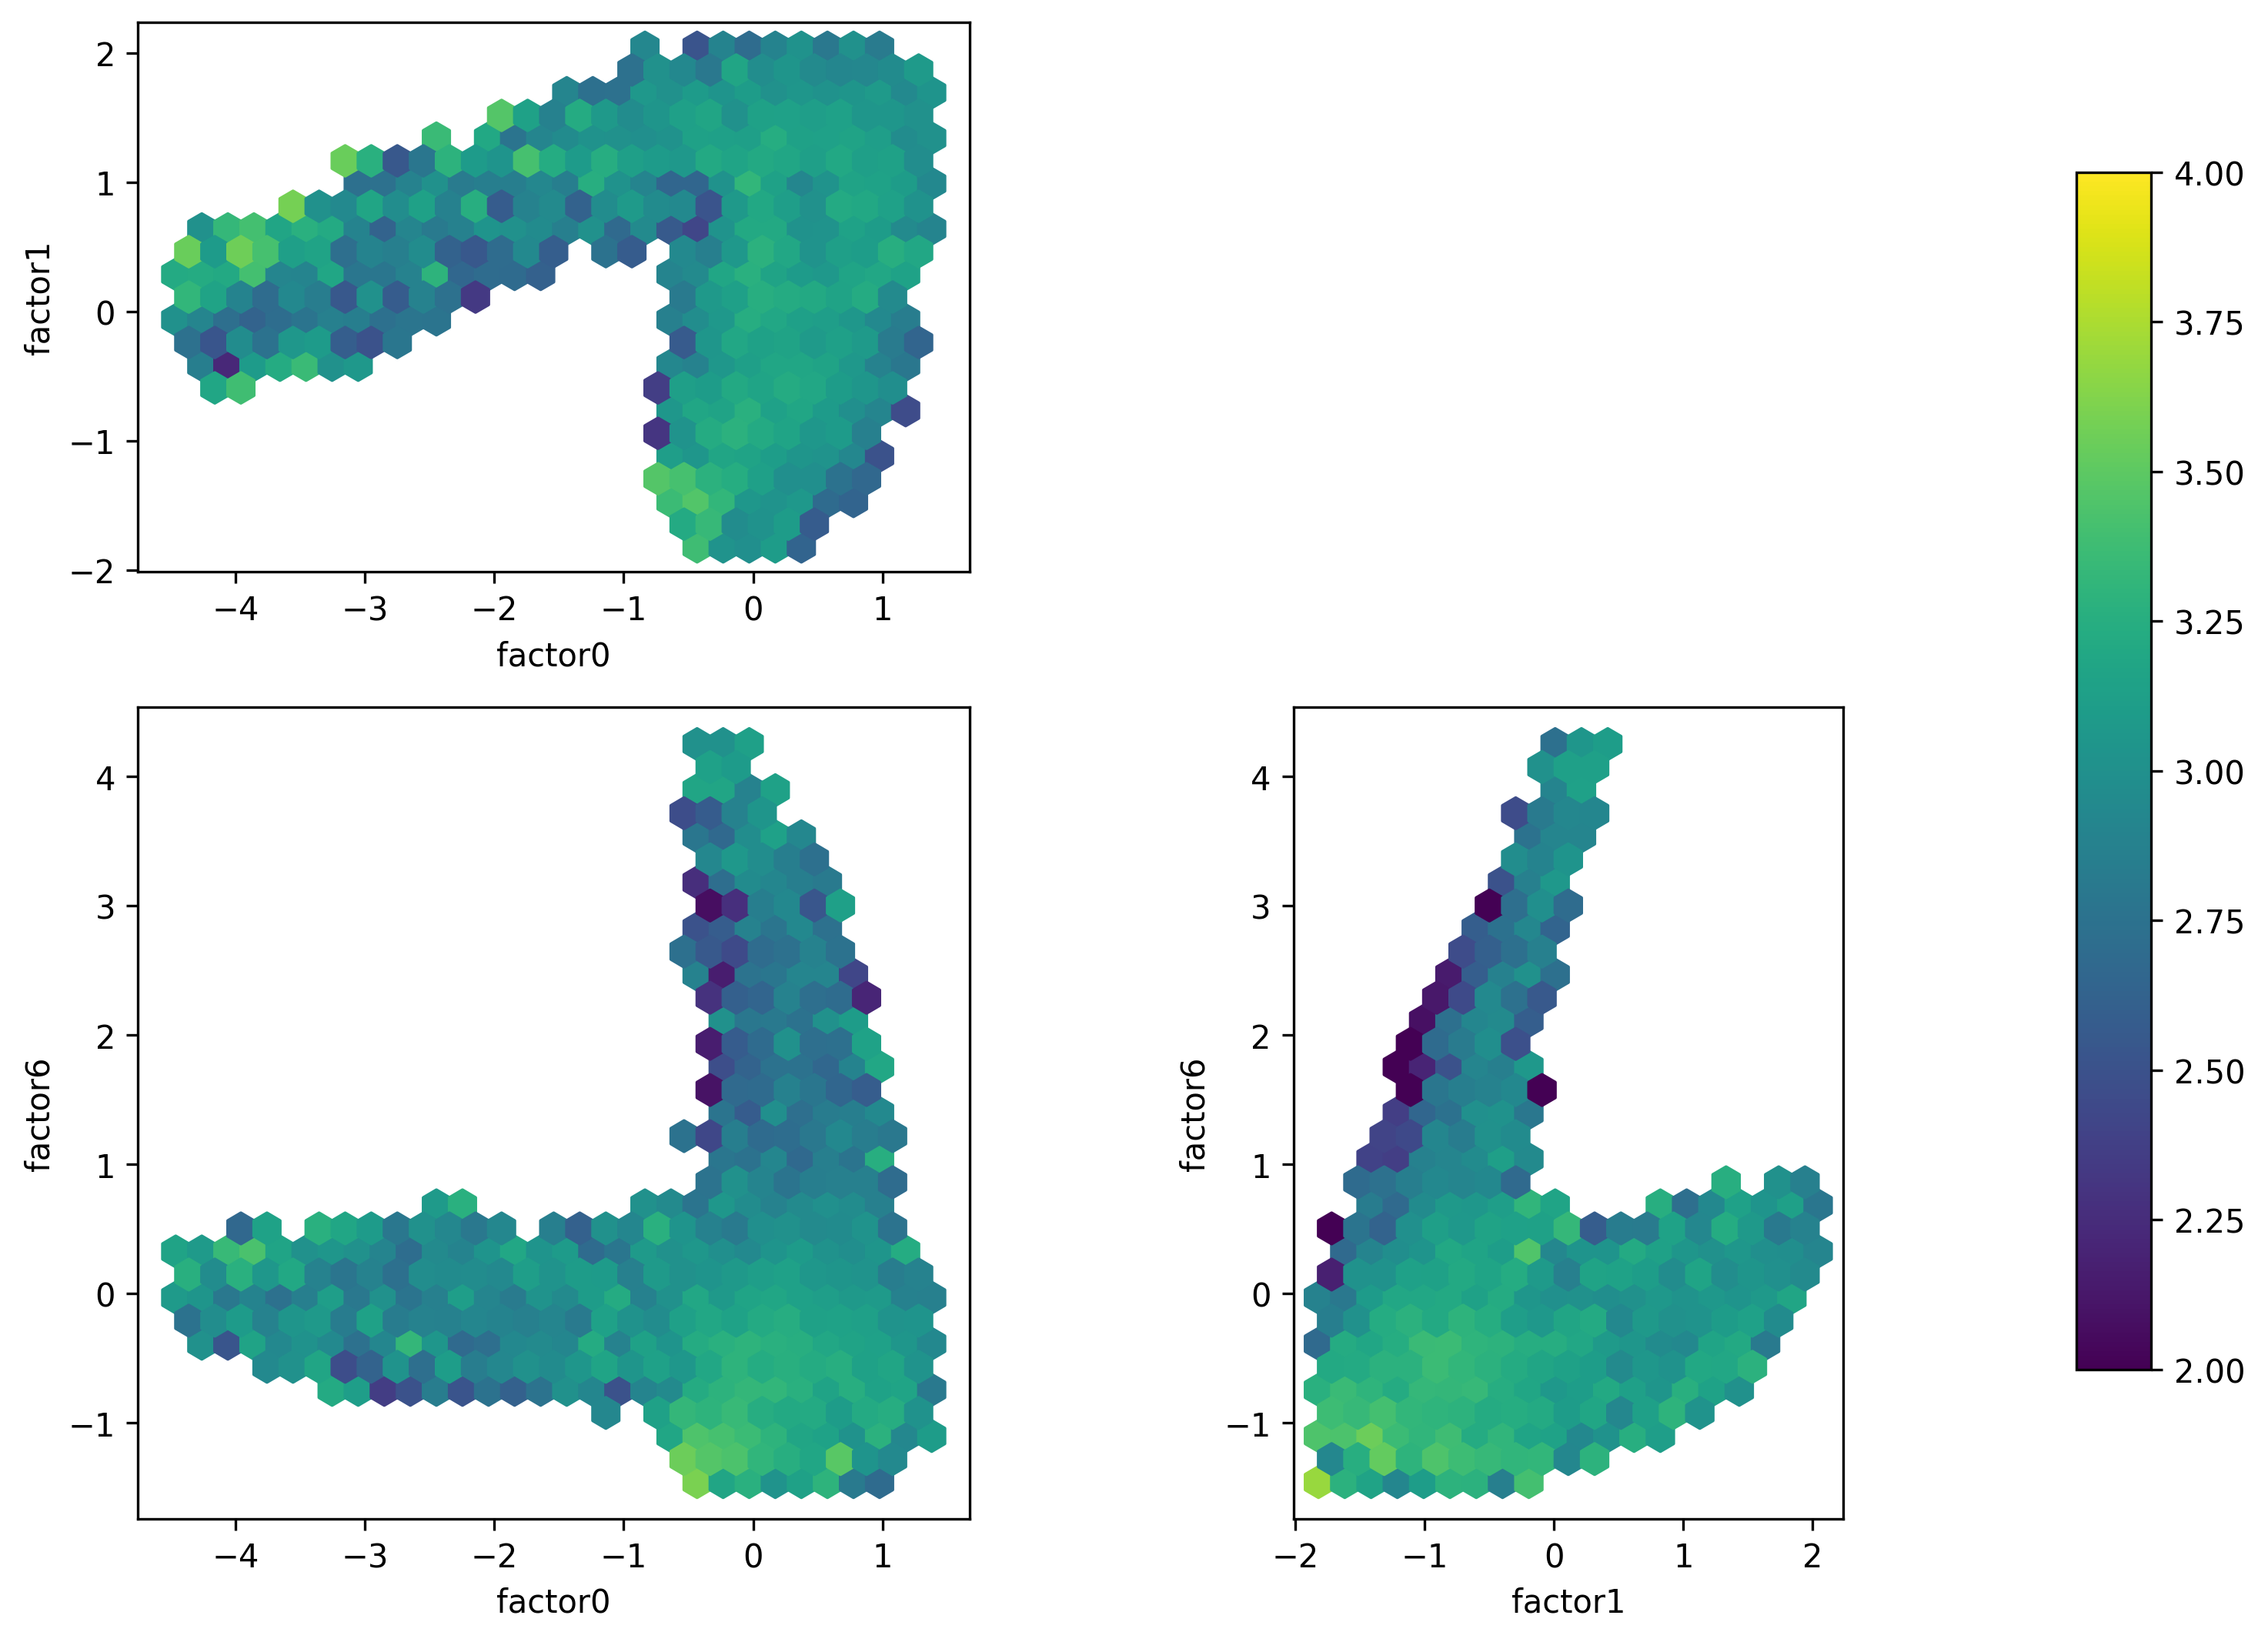

In [143]:
lims = [np.quantile(df[f], (0.005, 0.995)) for f in [f"factor{i}" for i in range(7)]]
heights = [np.diff(lims[i])[0] for i in [1, 6]]
widths = [np.diff(lims[i])[0] for i in [0, 1]]

fig = plt.figure(figsize=(11, 7), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(2, 2, height_ratios=heights, width_ratios=widths)


ax01 = fig.add_subplot(gs[0, 0], aspect="equal")
ax06 = fig.add_subplot(gs[1, 0], aspect="equal")
ax16 = fig.add_subplot(gs[1, 1], aspect="equal")


# ax05 = fig.add_subplot(gs[2, 0], aspect="equal")
# ax15 = fig.add_subplot(gs[2, 1], aspect="equal")
# ax32 = fig.add_subplot(gs[3, 0], aspect="equal")
# ax42 = fig.add_subplot(gs[3, 1], aspect="equal")


plots = [
    (ax06, "factor0", "factor6"),
    (ax01, "factor0", "factor1"),
    (ax16, "factor1", "factor6"),
    #     (ax05, "factor0", "factor5"),
    #     (ax15, "factor1", "factor5"),
    #     (ax32, "factor3", "factor2"),
    #     (ax42, "factor4", "factor2"),
]

C = df["Rooms"]
vmin, vmax = np.quantile(C, (0.05, 0.95))

for ax, x, y in plots:
    plot_hexbin_equal(
        df[x], df[y], C, np.mean, vmin=vmin, vmax=vmax, mincnt=10, gridscale=0.2, ax=ax
    )

fig.colorbar(ax01.collections[0], ax=[ax for ax, _, _ in plots], pad=0.1, shrink=0.8)
# fig.tight_layout()

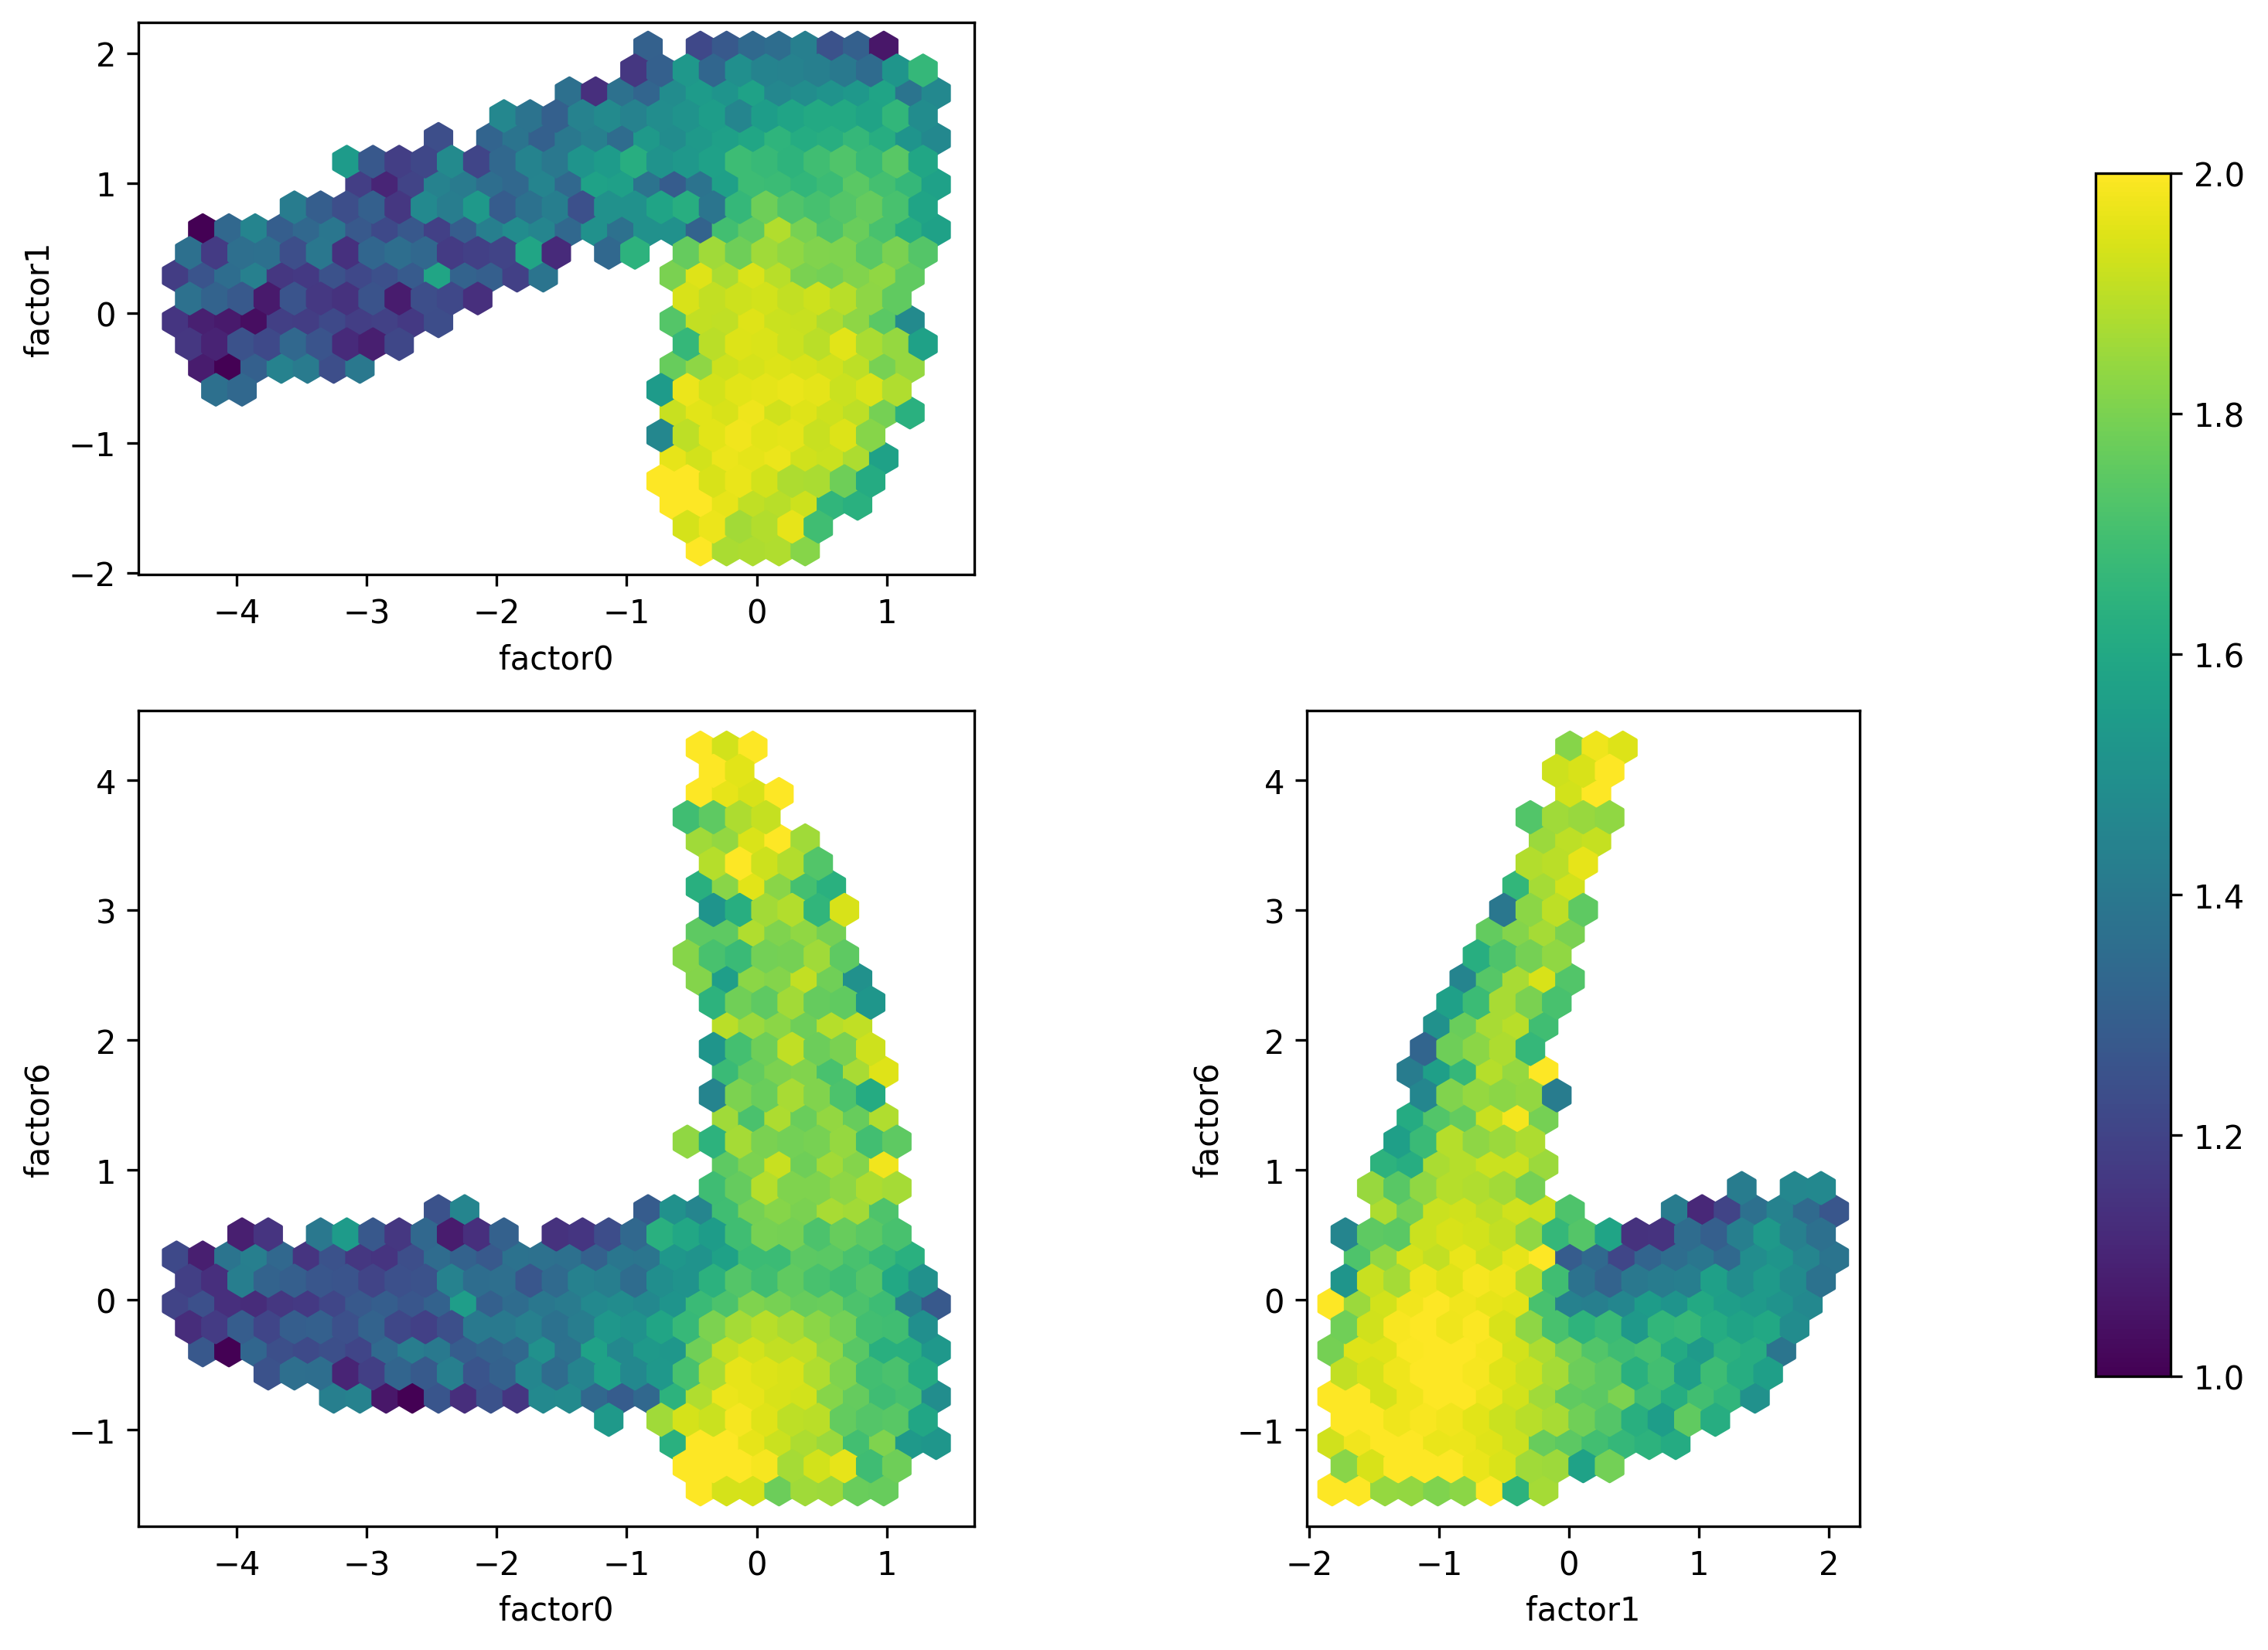

In [146]:
lims = [np.quantile(df[f], (0.005, 0.995)) for f in [f"factor{i}" for i in range(7)]]

heights = [np.diff(lims[i])[0] for i in [1, 6]]
widths = [np.diff(lims[i])[0] for i in [0, 1]]

fig = plt.figure(figsize=(11, 7), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(2, 2, height_ratios=heights, width_ratios=widths)


ax01 = fig.add_subplot(gs[0, 0], aspect="equal")
ax06 = fig.add_subplot(gs[1, 0], aspect="equal")
ax16 = fig.add_subplot(gs[1, 1], aspect="equal")


# ax05 = fig.add_subplot(gs[2, 0], aspect="equal")
# ax15 = fig.add_subplot(gs[2, 1], aspect="equal")
# ax32 = fig.add_subplot(gs[3, 0], aspect="equal")
# ax42 = fig.add_subplot(gs[3, 1], aspect="equal")


plots = [
    (ax06, "factor0", "factor6"),
    (ax01, "factor0", "factor1"),
    (ax16, "factor1", "factor6"),
    #     (ax05, "factor0", "factor5"),
    #     (ax15, "factor1", "factor5"),
    #     (ax32, "factor3", "factor2"),
    #     (ax42, "factor4", "factor2"),
]

C = df["Baths"]
vmin, vmax = np.quantile(C, (0.05, 0.95))

for ax, x, y in plots:
    plot_hexbin_equal(
        df[x], df[y], C, np.mean, vmin=vmin, vmax=vmax, mincnt=10, gridscale=0.2, ax=ax
    )

fig.colorbar(ax01.collections[0], ax=[ax for ax, _, _ in plots], pad=0.1, shrink=0.8)
# fig.tight_layout()

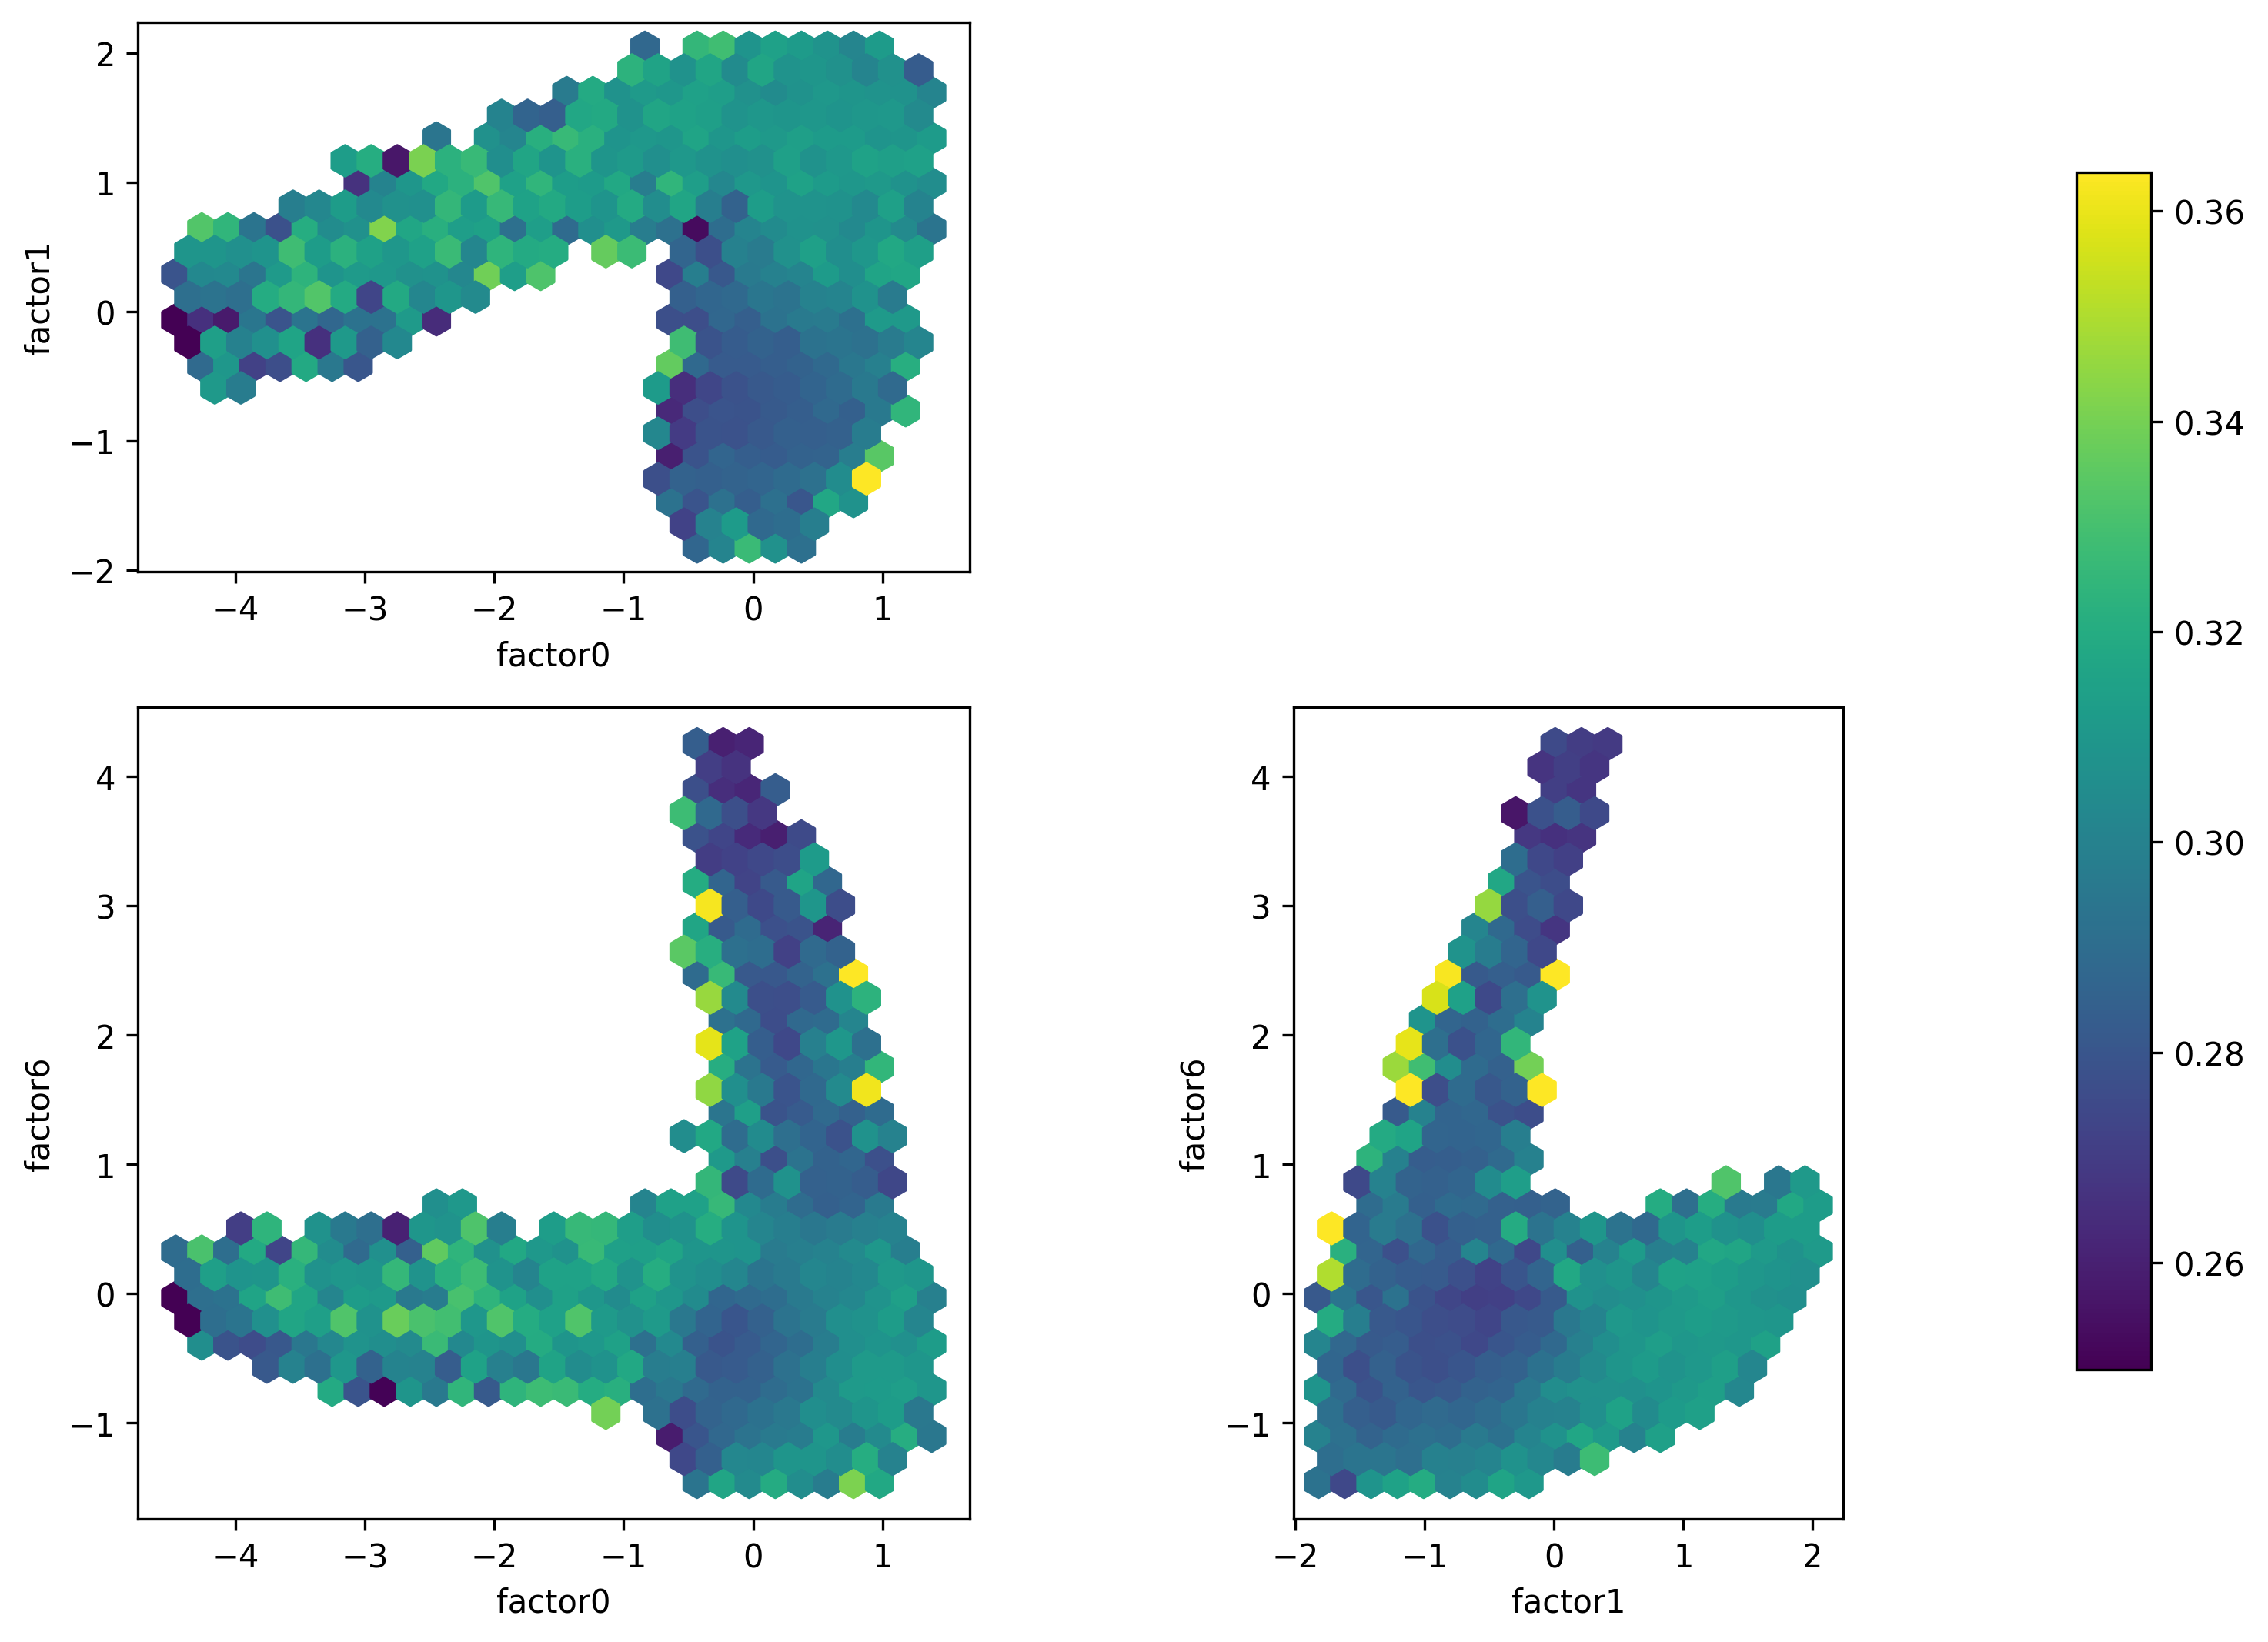

In [147]:
lims = [np.quantile(df[f], (0.005, 0.995)) for f in [f"factor{i}" for i in range(7)]]

heights = [np.diff(lims[i])[0] for i in [1, 6]]
widths = [np.diff(lims[i])[0] for i in [0, 1]]

fig = plt.figure(figsize=(11, 7), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(2, 2, height_ratios=heights, width_ratios=widths)


ax01 = fig.add_subplot(gs[0, 0], aspect="equal")
ax06 = fig.add_subplot(gs[1, 0], aspect="equal")
ax16 = fig.add_subplot(gs[1, 1], aspect="equal")


# ax05 = fig.add_subplot(gs[2, 0], aspect="equal")
# ax15 = fig.add_subplot(gs[2, 1], aspect="equal")
# ax32 = fig.add_subplot(gs[3, 0], aspect="equal")
# ax42 = fig.add_subplot(gs[3, 1], aspect="equal")


plots = [
    (ax06, "factor0", "factor6"),
    (ax01, "factor0", "factor1"),
    (ax16, "factor1", "factor6"),
    #     (ax05, "factor0", "factor5"),
    #     (ax15, "factor1", "factor5"),
    #     (ax32, "factor3", "factor2"),
    #     (ax42, "factor4", "factor2"),
]

C = df["AREA_LDK"] / df["AREA_UNIT"]
vmin, vmax = np.quantile(C, (0.1, 0.9))

for ax, x, y in plots:
    plot_hexbin_equal(
        df[x],
        df[y],
        C,
        np.median,
        vmin=vmin,
        vmax=vmax,
        mincnt=10,
        gridscale=0.2,
        ax=ax,
    )

fig.colorbar(ax01.collections[0], ax=[ax for ax, _, _ in plots], pad=0.1, shrink=0.8)
# fig.tight_layout()

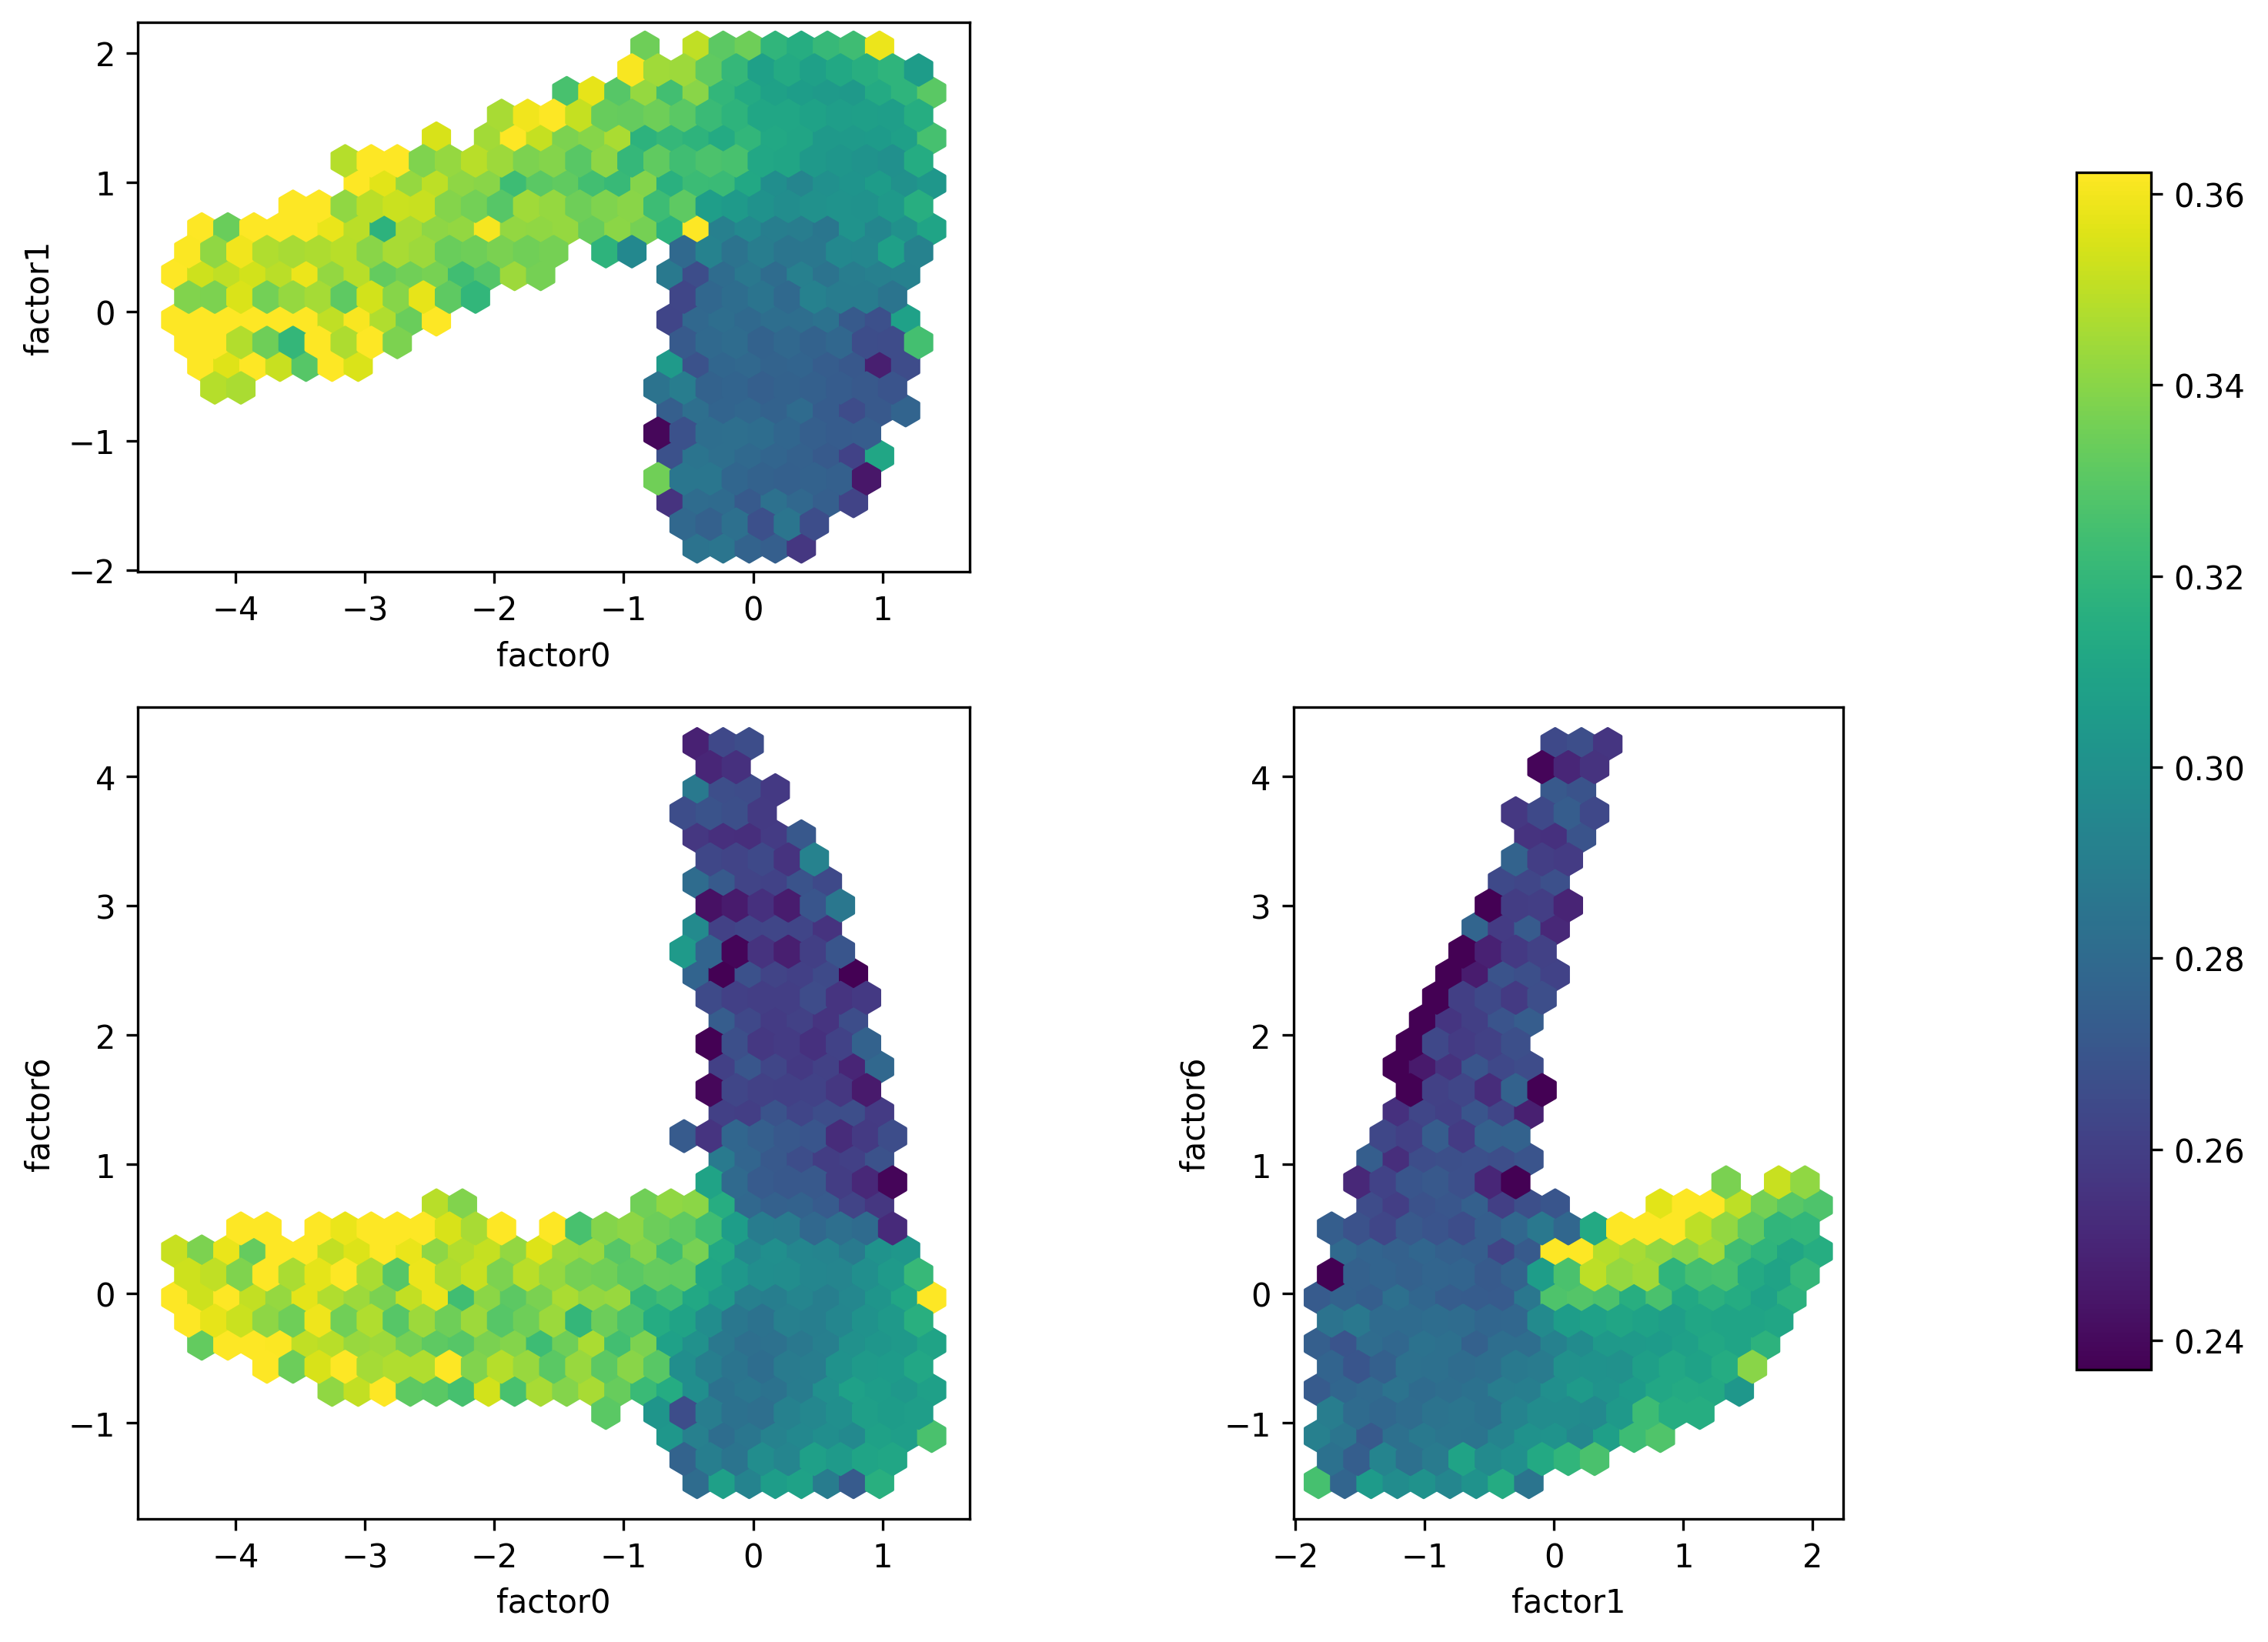

In [148]:
lims = [np.quantile(df[f], (0.005, 0.995)) for f in [f"factor{i}" for i in range(7)]]

heights = [np.diff(lims[i])[0] for i in [1, 6]]
widths = [np.diff(lims[i])[0] for i in [0, 1]]

fig = plt.figure(figsize=(11, 7), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(2, 2, height_ratios=heights, width_ratios=widths)


ax01 = fig.add_subplot(gs[0, 0], aspect="equal")
ax06 = fig.add_subplot(gs[1, 0], aspect="equal")
ax16 = fig.add_subplot(gs[1, 1], aspect="equal")


# ax05 = fig.add_subplot(gs[2, 0], aspect="equal")
# ax15 = fig.add_subplot(gs[2, 1], aspect="equal")
# ax32 = fig.add_subplot(gs[3, 0], aspect="equal")
# ax42 = fig.add_subplot(gs[3, 1], aspect="equal")


plots = [
    (ax06, "factor0", "factor6"),
    (ax01, "factor0", "factor1"),
    (ax16, "factor1", "factor6"),
    #     (ax05, "factor0", "factor5"),
    #     (ax15, "factor1", "factor5"),
    #     (ax32, "factor3", "factor2"),
    #     (ax42, "factor4", "factor2"),
]

C = df["AREA_BEDROOM"] / df["AREA_UNIT"]
vmin, vmax = np.quantile(C, (0.1, 0.9))

for ax, x, y in plots:
    plot_hexbin_equal(
        df[x],
        df[y],
        C,
        np.median,
        vmin=vmin,
        vmax=vmax,
        mincnt=10,
        gridscale=0.2,
        ax=ax,
    )

fig.colorbar(ax01.collections[0], ax=[ax for ax, _, _ in plots], pad=0.1, shrink=0.8)
# fig.tight_layout()

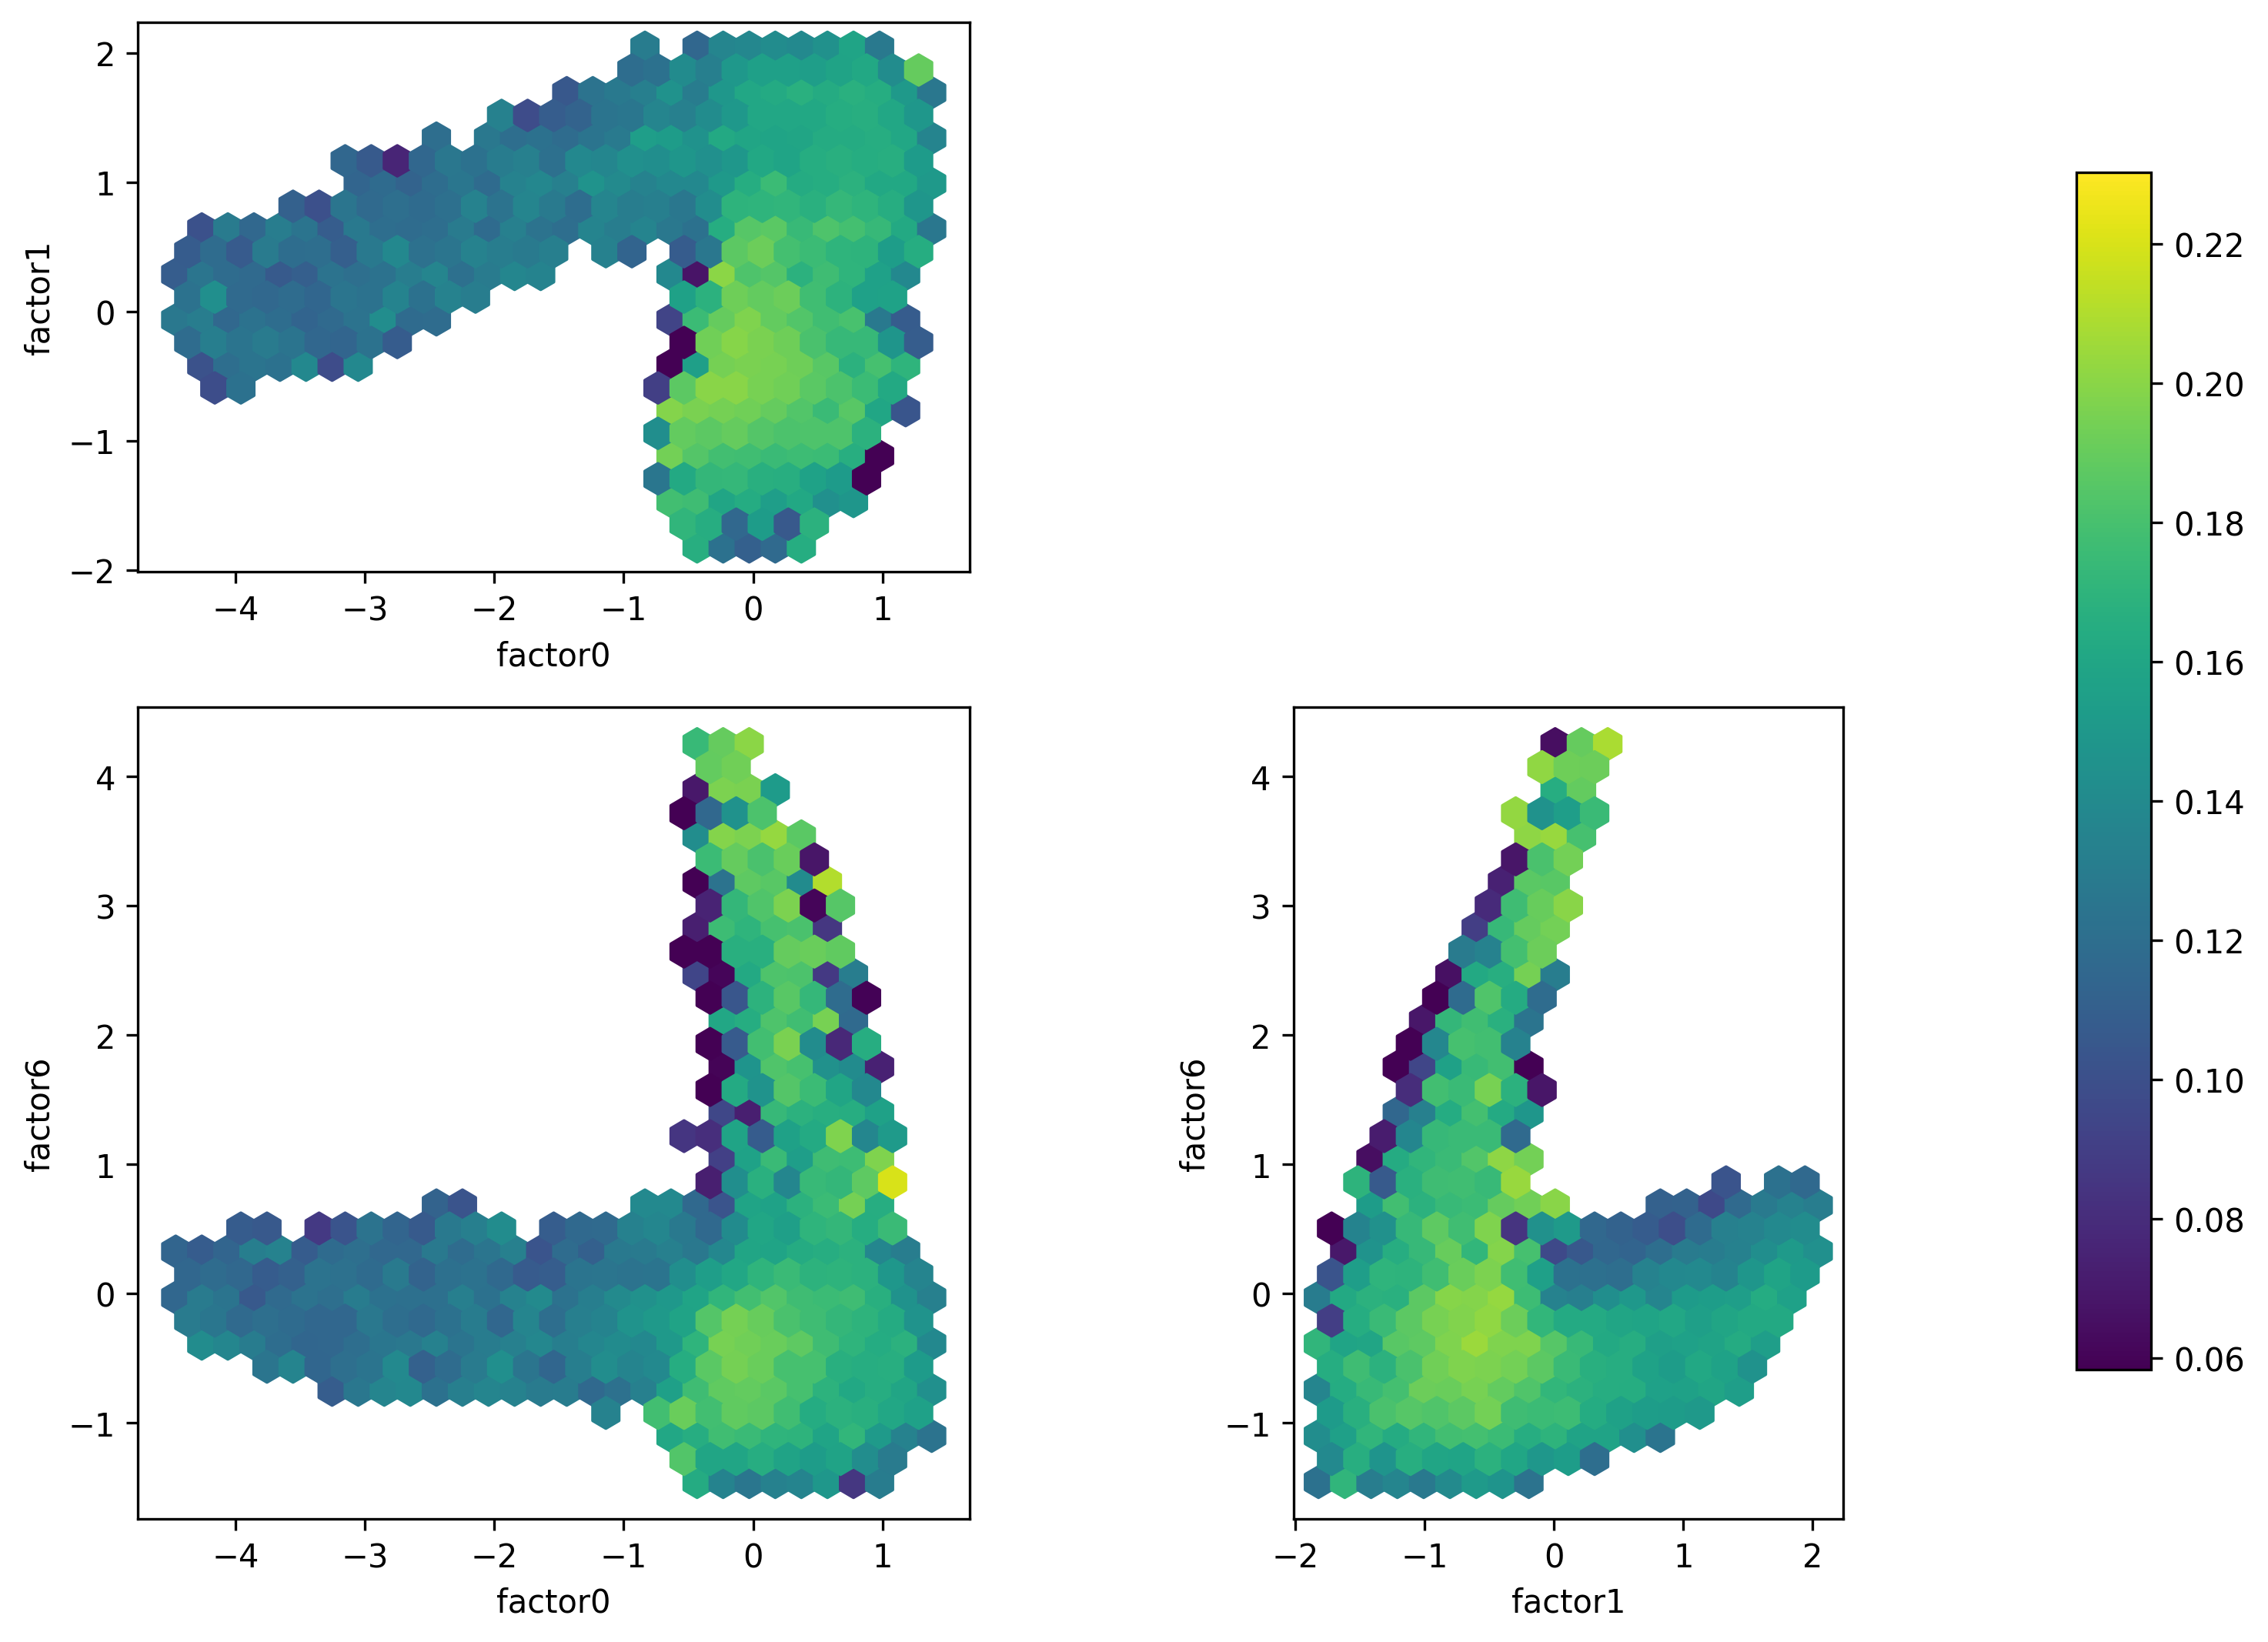

In [153]:
lims = [np.quantile(df[f], (0.005, 0.995)) for f in [f"factor{i}" for i in range(7)]]

# heights = [np.diff(lims[i])[0] for i in [1, 6, 5, 2]]
# widths = [np.diff(lims[i])[0] for i in [0, 1]]
# fig = plt.figure(figsize=(11, 15), dpi=300, constrained_layout=True)
# gs = fig.add_gridspec(4, 2, height_ratios=heights, width_ratios=widths)

heights = [np.diff(lims[i])[0] for i in [1, 6]]
widths = [np.diff(lims[i])[0] for i in [0, 1]]
fig = plt.figure(figsize=(11, 7), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(2, 2, height_ratios=heights, width_ratios=widths)


ax01 = fig.add_subplot(gs[0, 0], aspect="equal")
ax06 = fig.add_subplot(gs[1, 0], aspect="equal")
ax16 = fig.add_subplot(gs[1, 1], aspect="equal")

# ax05 = fig.add_subplot(gs[2, 0], aspect="equal")
# ax15 = fig.add_subplot(gs[2, 1], aspect="equal")
# ax32 = fig.add_subplot(gs[3, 0], aspect="equal")
# ax42 = fig.add_subplot(gs[3, 1], aspect="equal")

plots = [
    (ax06, "factor0", "factor6"),
    (ax01, "factor0", "factor1"),
    (ax16, "factor1", "factor6"),
    #     (ax05, "factor0", "factor5"),
    #     (ax15, "factor1", "factor5"),
    #     (ax32, "factor3", "factor2"),
    #     (ax42, "factor4", "factor2"),
]


C = df["AREA_BALCONY"] / df["AREA_UNIT"]
vmin, vmax = np.quantile(C, (0.1, 0.9))

for ax, x, y in plots:
    plot_hexbin_equal(
        df[x],
        df[y],
        C,
        np.median,
        vmin=vmin,
        vmax=vmax,
        mincnt=10,
        gridscale=0.2,
        ax=ax,
    )

fig.colorbar(ax01.collections[0], ax=[ax for ax, _, _ in plots], pad=0.1, shrink=0.8)
# fig.tight_layout()